# Mid-Term Review - October 2024 - SnowC2

With physics + Arctic snow code modifications

In [1]:
# Env: sc2_v0
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os

In [2]:
# https://www.w3schools.com/python/python_classes.asp

class Site:
  def __init__(self, name, long_name, location, lat, lon, elevation, period, start, stop, period_used, run):
    self.name = name
    self.long_name = long_name
    self.location = location
    self.lat = lat
    self.lon = lon
    self.elevation = elevation
    self.period = period
    self.start = start
    self.stop = stop
    self.period_used = period_used
    self.run = run

exps = [
    # 'Ref_30min_ext',
    'DEF',
    # 'BUG_CORRECT',
    # 'BUG_CORRECT_TSNBT_OP1',
    'BUG_CORRECT_TSNBT_OP1_EZERO',
    'PHYS_ALL_SUBLI',
    'PHYS_ALL_SUBLI_COMPAC',
    'PHYS_ALL_SUBLI_COMPAC_calonne',

]

# SnowMIP
cdp = Site('cdp', 'Col de Porte, France', '45.30°N, 5.77°E', 45.30, 5.77, '1325 m', 
           '1 October 1994 to 30 September 2014', '1994-10-01', '2014-09-30', slice('1994-10-01', '2014-09-30'), exps)

rme = Site('rme', 'Reynolds Mountain East, Idaho, USA', '43.19°N, 116.78°W', 43.19, -116.78, '2060 m', 
           '1 October 1988 to 30 September 2008', '1988-10-01', '2008-09-30', slice('1988-10-01', '2008-09-30'), exps)

snb = Site('snb', 'Senator Beck, Colorado, US', '37.91°N, 107.73°W', 37.91, -107.73, '3714 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

swa = Site('swa', 'Swamp Angel, Colorado, USA', '37.91°N, 107.71°W', 37.91, -107.71, '3371 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

sap = Site('sap', 'Sapporo, Japan', '43.08°N, 141.34°E', 43.08, 141.34, '15 m', 
           '1 October 2005 to 30 September 2015', '2005-10-01', '2015-09-30', slice('2005-10-01', '2015-09-30'), exps)

sod = Site('sod', 'Sodankylä, Finland', '67.37°N, 26.63°E', 67.37, 26.63, '179 m', 
           '1 October 2007 to 30 September 2014', '2007-10-01', '2014-09-30', slice('2007-10-01', '2014-09-30'), exps)

wfj = Site('wfj', 'Weissfluhjoch, Switzerland', '46.83°N, 9.81°E', 46.83, 9.81, '2540 m', 
           '1 September 1996 to 31 August 2016', '1996-10-01', '2016-08-31', slice('1996-10-01', '2016-08-31'), exps)

# Arctic 
byl = Site('byl', 'Bylot Island, Canadian high Arctic', '73.15°N, 80.00°W', 73.15, -80.00, '25 m', 
           '11 July 2013 to 25 June 2019', '2013-07-11', '2019-06-25', slice('2014-07-11', '2019-06-25'), 
           [
               # 'peat_30min_ext', 
               'peat_DEF',
               # 'peat_BUG_CORRECT',
               # 'peat_BUG_CORRECT_TSNBT_OP1',
               'peat_BUG_CORRECT_TSNBT_OP1_EZERO',
               'peat_PHYS_ALL_SUBLI',
               'peat_PHYS_ALL_SUBLI_COMPAC',
               'peat_PHYS_ALL_SUBLI_COMPAC_calonne',
           ])

umt = Site('umt', 'Umiujaq TUNDRA, northeastern Canada', '56.55877°N, 76.48234°W', 56.55877, -76.48234, '132 m', 
           '28 Sept 2012 to 15 October 2021', '2012-09-28', '2021-10-15', slice('2016-09-01', '2021-08-31'), 
           [
               # 'Ref', 
               'DEF',
               # 'BUG_CORRECT',
               # 'BUG_CORRECT_TSNBT_OP1',
               'BUG_CORRECT_TSNBT_OP1_EZERO',
               'PHYS_ALL_SUBLI',
               'PHYS_ALL_SUBLI_COMPAC',
               'PHYS_ALL_SUBLI_COMPAC_calonne',
           ])

# umf = Site('umf', 'Umiujaq FOREST, northeastern Canada', '56.55308°N, 76.47258°W', 56.55308, -76.47258, '82 m', 
#            '26 Nov 2015 to 19 October 2021', '2015-11-26', '2021-10-19', slice('2018-09-01', '2021-08-31'), 
#            ['Ref', 'EZERO'])


In [3]:
SnowMIP_sites = [cdp, rme, snb, swa, sap, sod, wfj]
# SnowMIP_sites = [cdp, rme, snb, sap, sod, wfj]
SnowArctic_sites = [byl, umt]

path_SnowMIP = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowMIP/'
path_SnowArctic = '/home/lalandmi/eccc/classic-develop/outputFiles/SnowArctic/'
path_Paul = '/home/lalandmi/Dropbox/data/SnowMIP/Paul/CLASS_Results'

ds_d_SnowMIP_list = []
for i, exp in enumerate(exps):
    paths_SnowMIP = [path_SnowMIP+site.name+'/'+'run_'+exp for site in SnowMIP_sites]
    # Change the syntax as the ref run is not necessarily having the same name for all sites
    paths_SnowArctic = [path_SnowArctic+site.name+'/'+'run_'+site.run[i] for site in SnowArctic_sites]
    paths = paths_SnowMIP + paths_SnowArctic
    ds_d_SnowMIP_list.append([xr.open_mfdataset(path+'/*_daily.nc').squeeze().load() for path in paths])


# ds_d_Paul_list = []
# for site in SnowMIP_sites:
#     df_Paul = pd.read_csv(path_Paul+'/CLASS_sv_REF_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.txt', delim_whitespace=True)
#     df_Paul.index = pd.to_datetime(df_Paul[['year', 'month', 'day', 'hour']]).values
#     df_Paul= df_Paul.drop(columns=['year', 'month', 'day', 'hour'])
#     df_Paul.albsn = df_Paul.albsn.replace({0 : np.nan})
#     df_Paul.albs = df_Paul.albs.replace({0 : np.nan})
#     df_Paul.tsn = df_Paul.tsn.replace({-999 : np.nan})
#     df_Paul.tsns = df_Paul.tsns.replace({-999 : np.nan})
#     ds_Paul_h = df_Paul.to_xarray()
#     ds_Paul_h = ds_Paul_h.rename({'index': 'time'})
#     ds_Paul_d = ds_Paul_h.resample(time='D').mean().load()
#     ds_Paul_d = ds_Paul_d.assign_coords(layer=[0.05 , 0.225, 2.225]) # center of Paul's soil layers (DELZ = [0.1, 0.25, 3.75])
    

#     # Combine the Soil temperature in one variable
#     ds_Paul_d = ds_Paul_d.assign(
#         tsl=(('layer', 'time'), [
#             list(ds_Paul_d['tsl:1'].values),
#             list(ds_Paul_d['tsl:2'].values),
#             list(ds_Paul_d['tsl:3'].values),
#         ])
#     )
        
#     ds_d_Paul_list.append(ds_Paul_d)

## Set soil levels

In [4]:
path = "/home/lalandmi/eccc/classic-develop/inputFiles/SnowMIP/cdp"
rsfile = xr.open_dataset(path+'/rsfile_spinup-final_Ref.nc')

In [5]:
def assign_center_depth(ds, rsfile):
    layer_c = []
    for i in range(len(rsfile.DELZ)):
        if i == 0:
            layer_c.append(rsfile.DELZ.cumsum().values[i]/2)
        else:
            layer_c.append(rsfile.DELZ.cumsum().values[i-1] + rsfile.DELZ.values[i]/2)
    with xr.set_options(keep_attrs=True):
        ds = ds.assign_coords(layer=ds.layer*0+layer_c)
    return ds

In [6]:
for i, exp in enumerate(exps):
    for j in range(len(SnowMIP_sites+SnowArctic_sites)):
        ds_d_SnowMIP_list[i][j] = assign_center_depth(ds_d_SnowMIP_list[i][j], rsfile)

## Compare with obs

In [7]:
path_menard2019 = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all'

ds_d_Obs_list = []
for site in SnowMIP_sites:
    ds_h_eval_menard2019 = xr.open_dataset(path_menard2019+'/obs_insitu_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.nc')
    ds_d_eval_menard2019 = ds_h_eval_menard2019.resample(time='D').mean().load()
    ds_d_Obs_list.append(ds_d_eval_menard2019)

In [8]:
path_obs_byl = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Bylot'
path_obs_umt = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'
# path_obs_umf = '/home/lalandmi/Dropbox/data/ESM-SnowMIP_all/Umiujaq/Domine-etal_2024/datasets'

# path_obs_list = [path_obs_byl, path_obs_umt, path_obs_umf]
path_obs_list = [path_obs_byl, path_obs_umt]
for site, path in zip(SnowArctic_sites, path_obs_list):
    ds_h_obs = xr.open_dataset(path+'/obs_insitu_'+site.name+'_'+site.start[:4]+'_'+site.stop[:4]+'.nc').load()
    if site.name == 'byl':
        ds_h_obs['albs'] = ds_h_obs.albs.where(ds_h_obs.flag_albs_ERA5 == 0).where(ds_h_obs.albs < 1) # to avoid > 1 albedo values
    if site.name == 'umt':
        ds_h_obs = ds_h_obs.mean(dim='veg') # average over lichen and lowshrub area (tsl)
    # Remove albs for Arctic sites (wrong values)
    if site.name in ['byl', 'umt']:
        ds_h_obs = ds_h_obs.drop_vars('albs')
    ds_d_obs = ds_h_obs.resample(time='D').mean().load()
    ds_d_Obs_list.append(ds_d_obs)

## Merge Arctic and SnowMIP

In [9]:
# ds_d_Obs_list = ds_d_Obs_list + ds_d_Obs_Arctic_list
# ds_d_SnowMIP_list = ds_d_SnowMIP_list + ds_d_SnowArctic_list

### SD

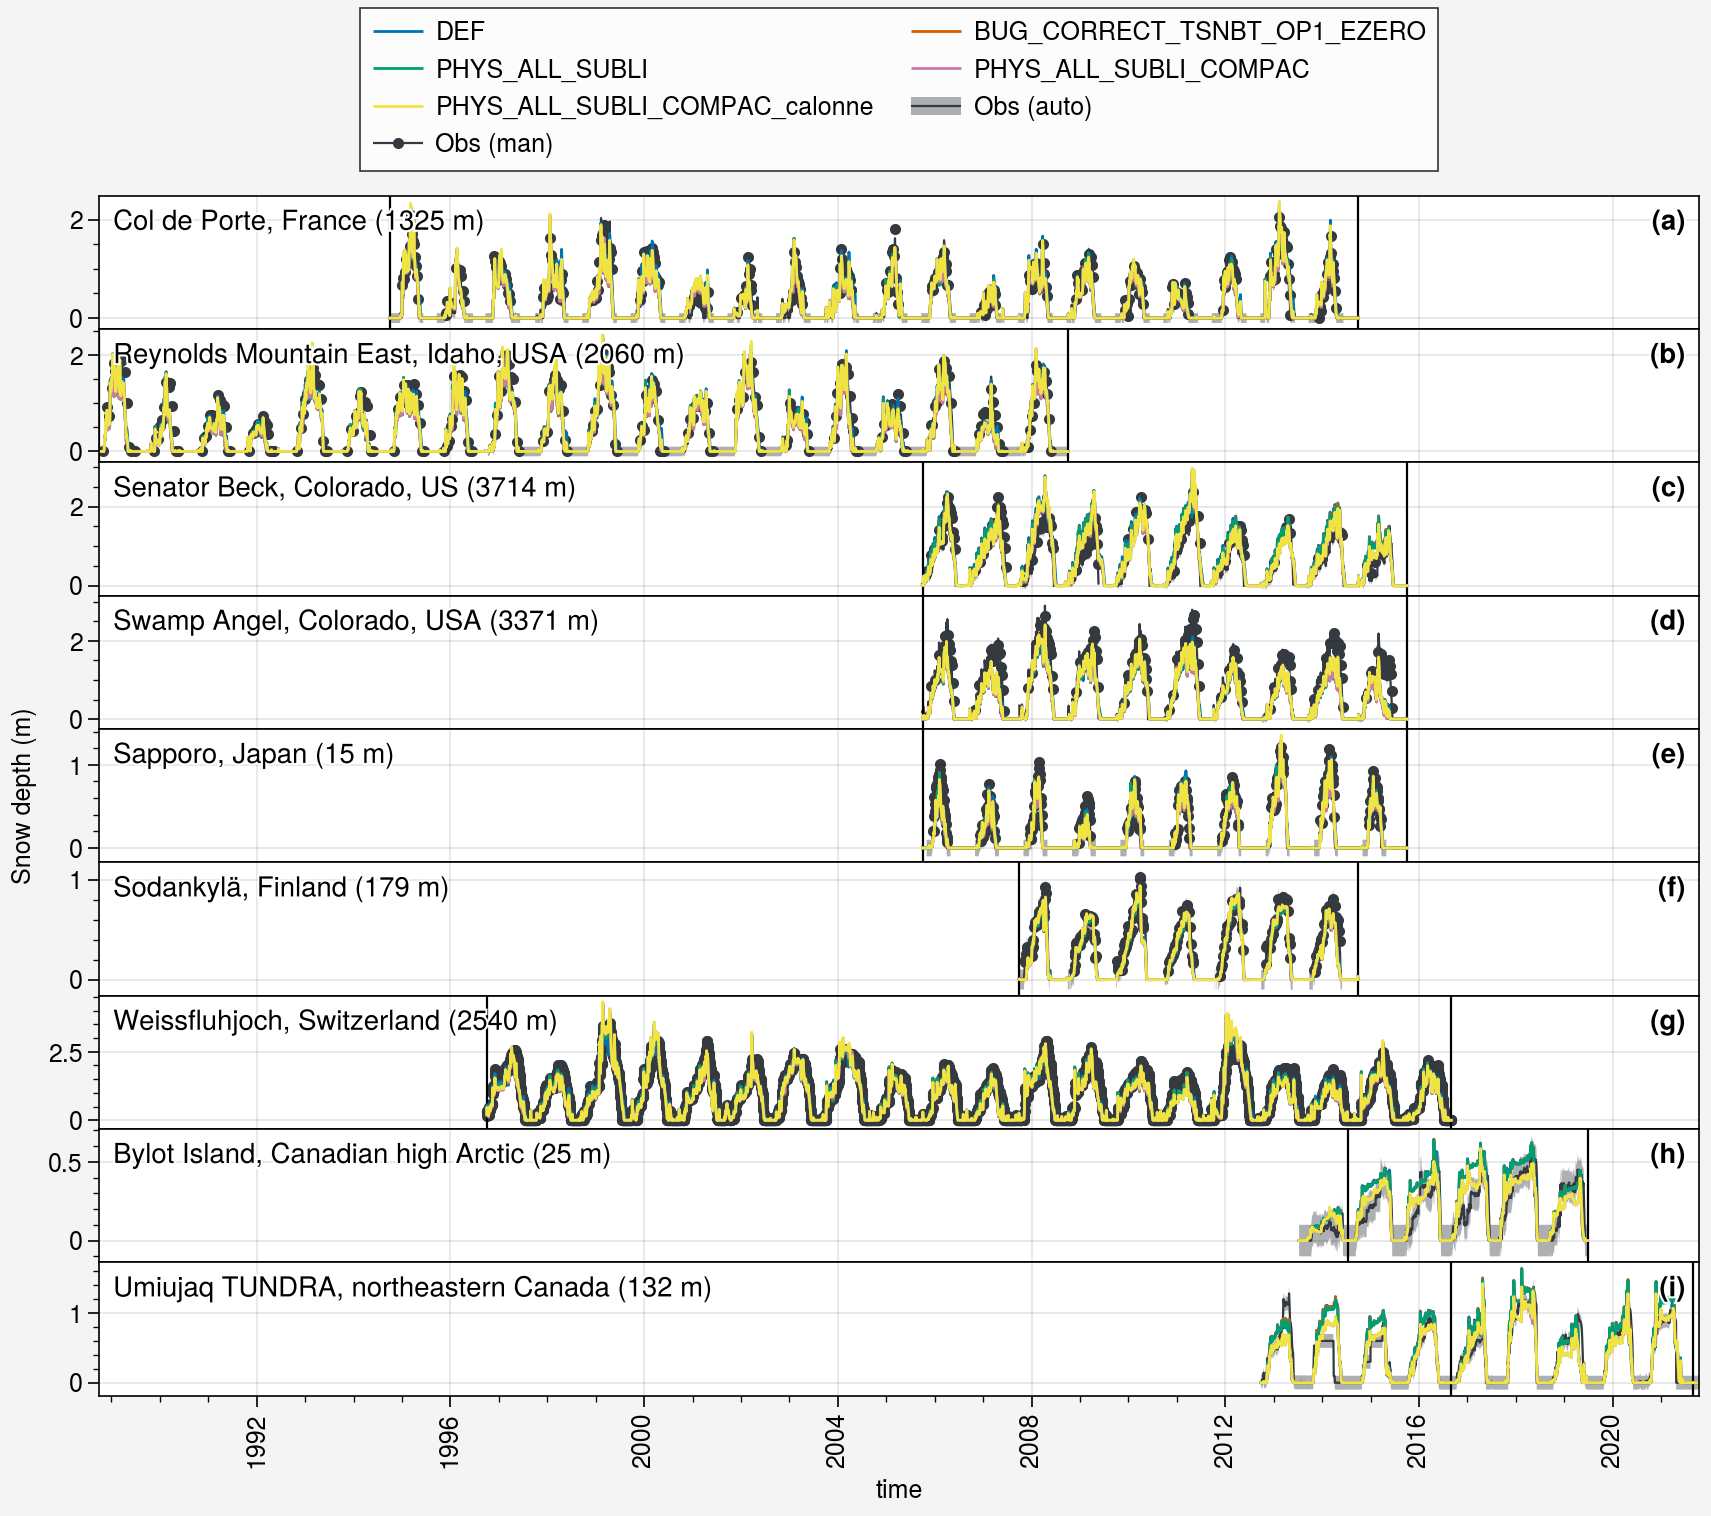

In [10]:
fig, axs = pplt.subplots(nrows=len(SnowMIP_sites+SnowArctic_sites), refaspect=12, refwidth=8, space=0)

color_obs = 'gray8'

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    # Model 
    h_exps = []
    for j, exp in enumerate(exps): 
        h = axs[i].plot(ds_d_SnowMIP_list[j][i].snd.sel(time=slice(site.start, site.stop)), label=exp, lw=1)
        h_exps.append(h)

    # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
    #     h_paul = axs[i].plot(ds_d_Paul_list[i].snd.sel(time=slice(site.start, site.stop)), label='CLASS', color='red9', lw=1)
    
    # Obs
    shadedata = np.concatenate((
        np.expand_dims(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)).values+0.1, axis=0),
        np.expand_dims(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)).values-0.1, axis=0),), axis=0)
    h_obs_auto = axs[i].plot(ds_d_Obs_list[i].snd_auto.sel(time=slice(site.start, site.stop)), shadedata=shadedata, color=color_obs, 
                zorder=0, lw=0.8, label='Obs (auto)')
    
    if 'snd_man' in list(ds_d_Obs_list[i].keys()):
        h_obs_man = axs[i].plot(ds_d_Obs_list[i].snd_man.sel(time=slice(site.start, site.stop)), marker='.', color=color_obs, 
                    zorder=0, lw=0.8, label='Obs (man)')
    
    axs[i].format(ylabel='Snow depth (m)', ultitle=site.long_name+' ('+site.elevation+')')
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[0], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    axs[i].vlines(ds_d_SnowMIP_list[j][i].sel(time=site.period_used).time[-1], axs[i].get_ylim()[0], axs[i].get_ylim()[1], 
                  color='k', lw=0.8)
    


# axs[4].legend(ncols=5, loc='ll')
# fig.legend(h_exps+h_paul+h_obs_auto+h_obs_man, ncols=2, loc='t')
fig.legend(h_exps+h_obs_auto+h_obs_man, ncols=2, loc='t')

fig.format(abc='(a)', abcloc='ur')

# fig.suptitle('Col de Porte, France, 1325 m')
# fig.save('img/tn1_sd.jpg')

### Annual cycles

In [11]:
[site.name for site in SnowMIP_sites+SnowArctic_sites]

['cdp', 'rme', 'snb', 'swa', 'sap', 'sod', 'wfj', 'byl', 'umt']

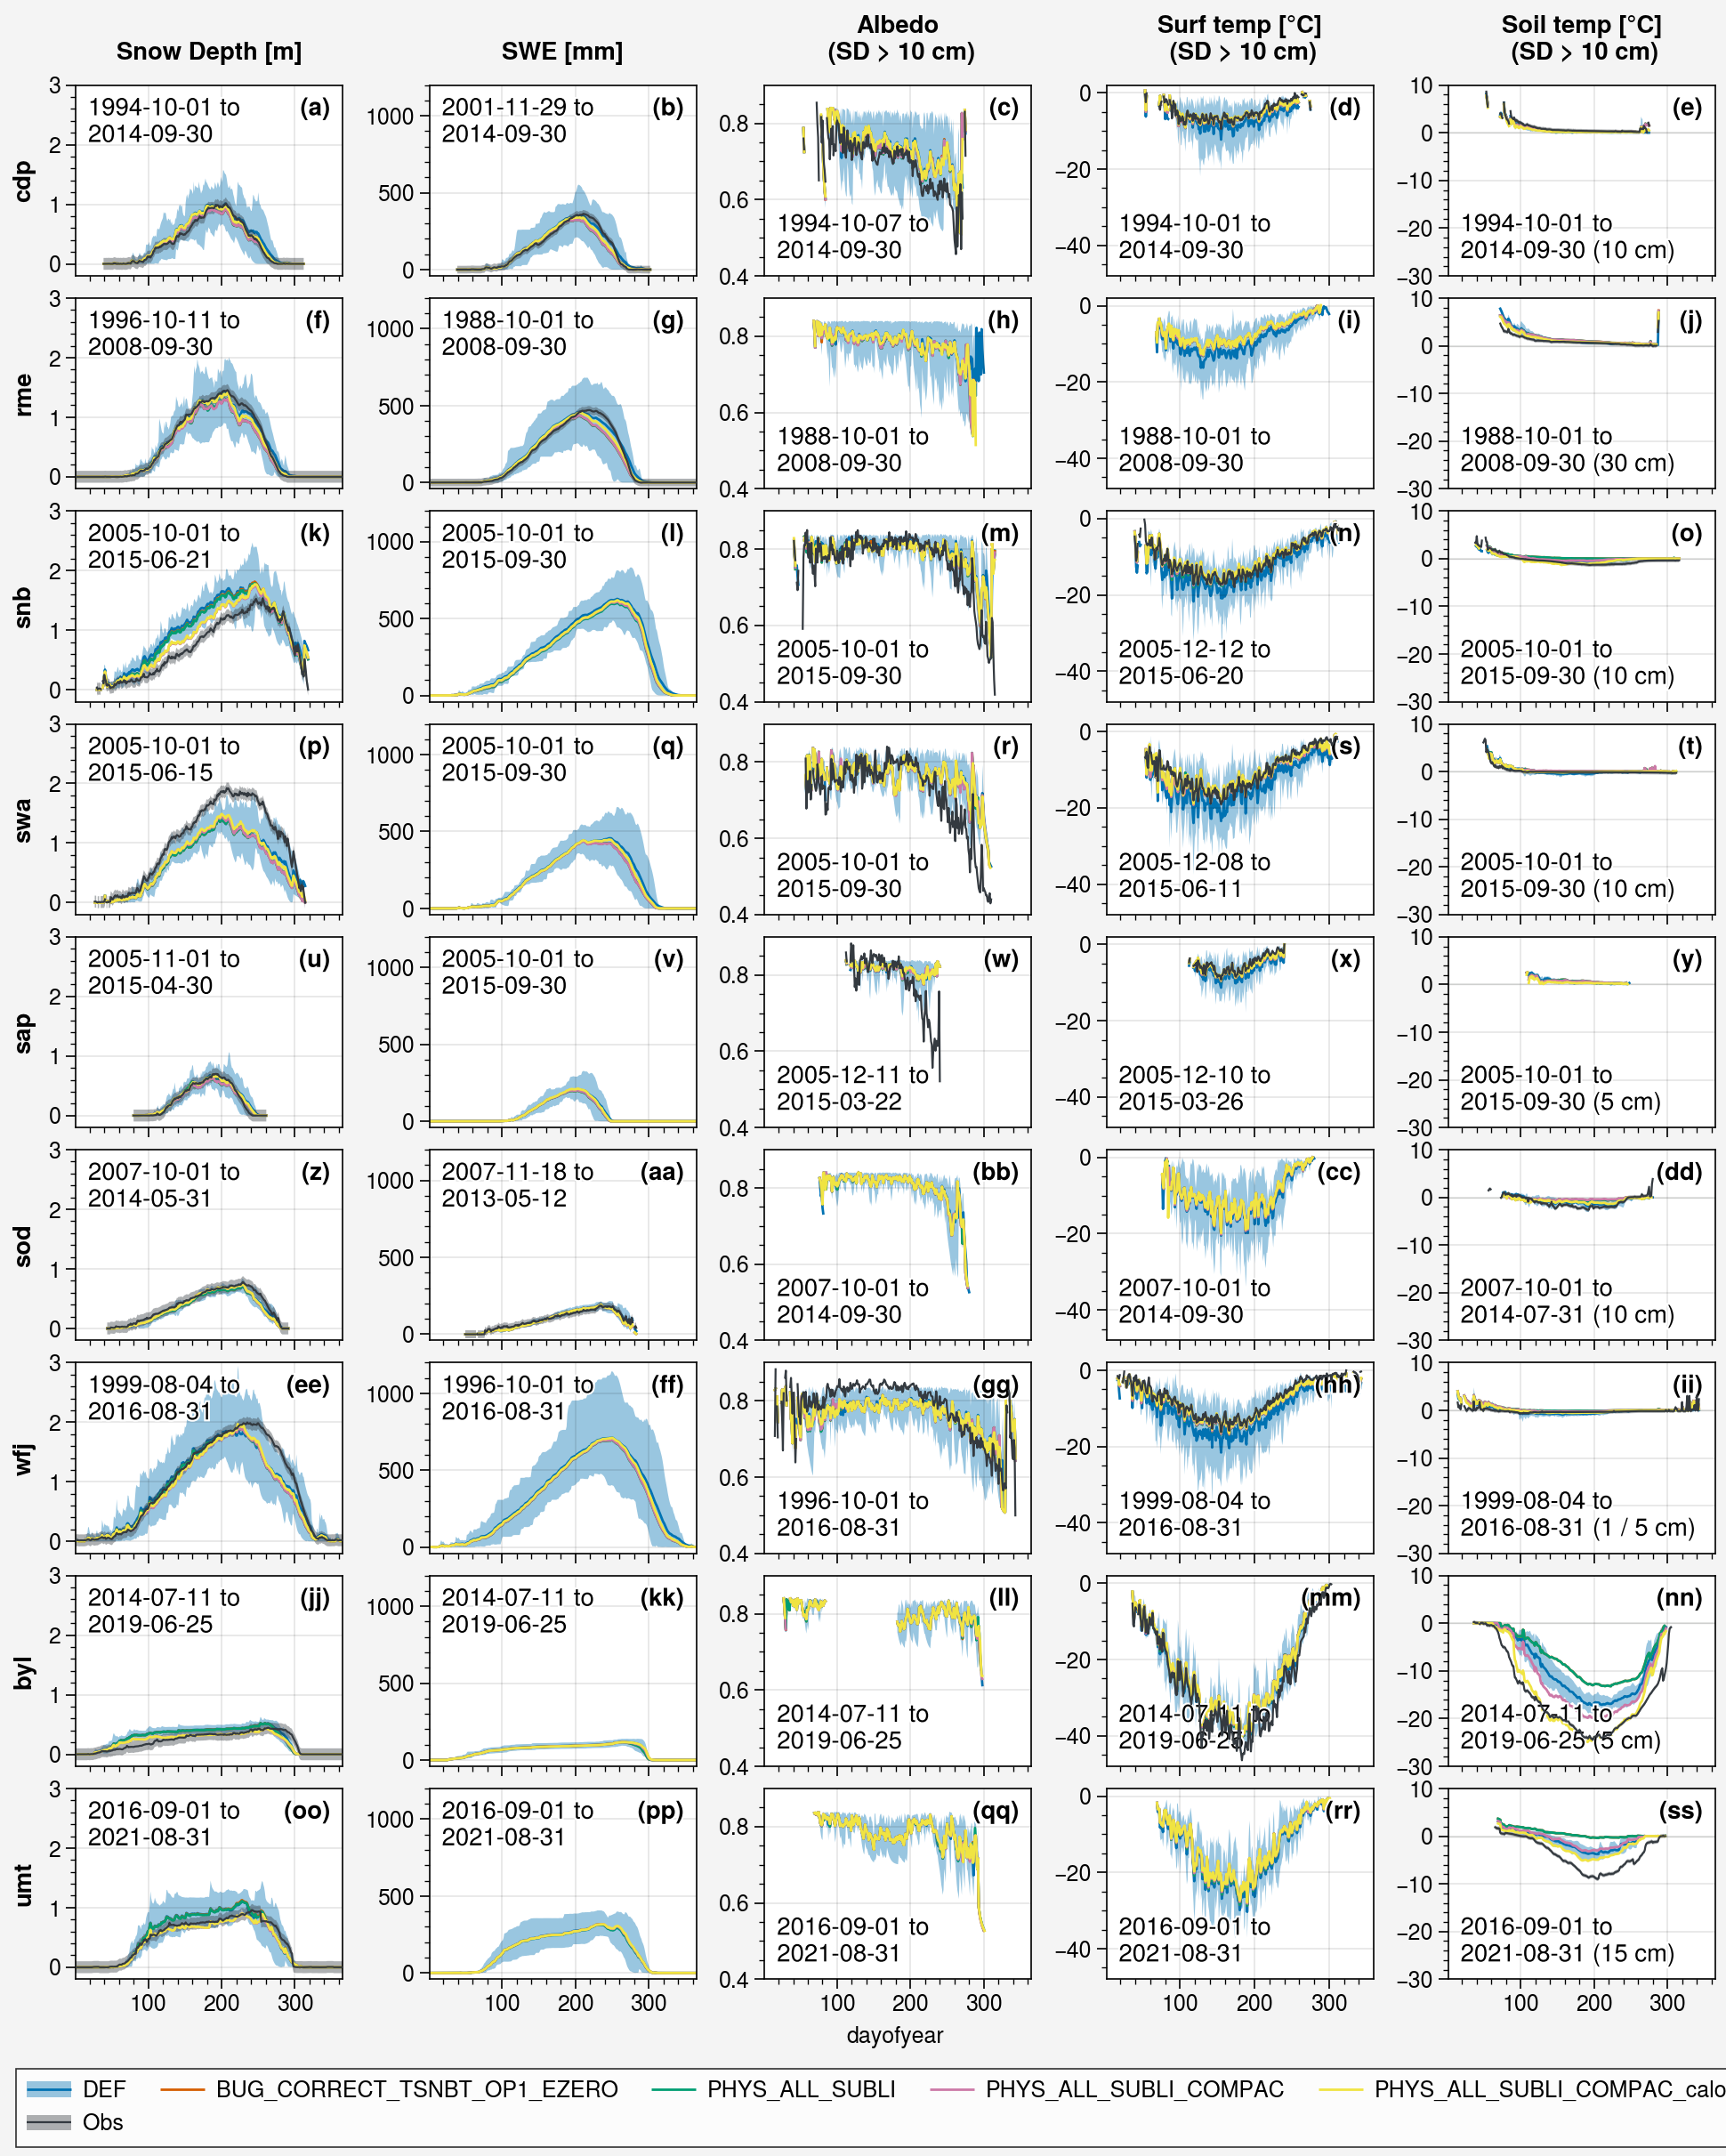

In [12]:
import warnings
warnings.filterwarnings("ignore")

color_obs = 'gray8'

# fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites+SnowArctic_sites), refwidth=1.5, sharey=0)
fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites+SnowArctic_sites), refwidth=1.5, sharey=0, hspace=1, refaspect=1.4)

# for i, site in enumerate([cdp]):
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):

    doy = 140
    period = site.period_used

    # Snow depth
    ax = axs[i*5+0]
    mask_obs = ~ds_d_Obs_list[i].snd_auto.sel(time=period).isnull()
    
    shadedata = ds_d_SnowMIP_list[0][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
    h1 = ax.plot(ds_d_SnowMIP_list[0][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
    h_exps = []
    for j, exp in enumerate(exps[1:]):
        h = ax.plot(ds_d_SnowMIP_list[j+1][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                 .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
        h_exps.append(h)

    # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
    #     h_paul = ax.plot(ds_d_Paul_list[i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
    #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
    
    obs = ds_d_Obs_list[i].snd_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
    shadedata = np.concatenate((np.expand_dims(obs.values+0.1, axis=0), np.expand_dims(obs.values-0.1, axis=0),), axis=0)
    h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
    ax.format(ylabel='', ylim=(-0.2,3),
              ultitle=str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
              str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[-1].values)[:10])    
    # ax.legend(h1+h_exps+h_paul+h_obs, loc='ul', ncols=1)
    
    # Snow Water Equivalent
    ax = axs[i*5+1]

    if 'snw_auto' in list(ds_d_Obs_list[i].keys()):
        mask_obs = ~ds_d_Obs_list[i].snw_auto.sel(time=period).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        #     h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
        #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        obs = ds_d_Obs_list[i].snw_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        shadedata = np.concatenate((np.expand_dims(obs.values+25, axis=0), np.expand_dims(obs.values-25, axis=0),), axis=0)
        h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
        ax.format(ylabel='', ylim=(-40,1200),
                  ultitle=str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                  str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        #     h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).groupby('time.dayofyear').mean()\
        #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(-40,1200), ultitle=period.start+' to\n'+ period.stop)


    # Albedo (need to add a condition albsn > 0.4 because a few values are 0 in the model -> bug? (e.g., at Saporo)
    # + low values are observed in the begining of the season (probably due to not full SCF coveraged)
    ax = axs[i*5+2]
    lim_alb = 0.4
    lim_alb_sup = 0.9

    if 'albs' in list(ds_d_Obs_list[i].keys()):
        mask_obs = ~ds_d_Obs_list[i].albs.where(ds_d_Obs_list[i].albs > lim_alb).where(ds_d_Obs_list[i].albs < lim_alb_sup)\
                    .where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                    .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                     .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                     .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
                        .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                        .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
                        .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        #     h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
        #                     .where(ds_d_Paul_list[i].albsn < lim_alb_sup)\
        #                     .where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
        #                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        if site not in ['umt', 'byl']:
            obs = ds_d_Obs_list[i].albs.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
            h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
            ax.format(ylabel='', ylim=(0.4,0.9),
                      lltitle=str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                      str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                    .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').quantile([0.1, 0.9])\
                    .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
                    .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                     .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').mean()\
                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
                        .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
                        .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).groupby('time.dayofyear').mean()\
                        .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
            h_exps.append(h)

        # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        #     h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
        #                      .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
        #                     .where(ds_d_Paul_list[i].snd > 0.1).groupby('time.dayofyear').mean()\
        #                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(0.4,0.9), lltitle=period.start+' to\n'+ period.stop)
    
    
    # Surface temperature
    # Add condition on ts <= 0 on obs to avoid melting pachy areas to be counted
    ax = axs[i*5+3]

    if 'ts' in list(ds_d_Obs_list[i].keys()) and ds_d_Obs_list[i].ts.notnull().sum() != 0:
        mask_obs = ~ds_d_Obs_list[i].ts.sel(time=period).where(ds_d_Obs_list[i].ts <= 0)\
                    .where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()
        
        shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        #     h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
        #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
        #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
        
        obs = ds_d_Obs_list[i].ts.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
        ax.format(ylabel='', ylim=(-48,2),
                  lltitle=str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                  str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[-1].values)[:10]) 

    else:
        shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        #     h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1)\
        #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
        #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
        
        ax.format(ylabel='', ylim=(-48,2), lltitle=period.start+' to\n'+ period.stop)

    
    # Soil temperature
    ax = axs[i*5+4]

    if 'tsl' in list(ds_d_Obs_list[i].keys()):
        
        # Get the first soil layer from obs (except for byl)
        if site.name == 'byl':
            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[1].values.item(0) # 0.05 instead of 0.02
        else:
            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[0].values.item(0)

        # For wfj (otherwise NaN so take the first model level)
        if obs_sdepth < 0.01: 
            model_sdepth = 0.05
        else:
            model_sdepth = obs_sdepth
        mask_obs = ~ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()

        # Interp model on the first soil layer obs
        if obs_sdepth < 0.01: 
            ds_d_interp = ds_d_SnowMIP_list[0][i]
        else:
            ds_d_interp = ds_d_SnowMIP_list[0][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
        
        shadedata = ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):
            if obs_sdepth < 0.01: 
                ds_d_interp = ds_d_SnowMIP_list[j+1][i]
            else:
                ds_d_interp = ds_d_SnowMIP_list[j+1][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
            
            h = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        #     if obs_sdepth < 0.01: 
        #         ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
        #     else:
        #         ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
        #     h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
        #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
        #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)

        obs = ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(mask_obs).groupby('time.dayofyear').mean()\
                .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
        shadedata = np.concatenate((np.expand_dims(obs.values+0.4, axis=0), np.expand_dims(obs.values-0.4, axis=0),), axis=0)
        h_obs = ax.plot(obs, label='Obs', shadedata=shadedata, color=color_obs, lw=0.8, zorder=10)
        ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
        if site.name == 'byl':
            ylim=(-30, 10)
        else:
            ylim=(-30, 10)
            # ylim=(-5, 10)
        if obs_sdepth != model_sdepth: 
            ax.format(ylabel='', ylim=ylim,
                      lltitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                      str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
                         str(round(obs_sdepth*100))+' / '+str(round(model_sdepth*100))+' cm)') 
        else:
            ax.format(ylabel='', ylim=ylim,
                      lltitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
                      str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
                         str(round(obs_sdepth*100))+' cm)')

    else:
        model_sdepth = 0.05 # first level
        
        shadedata = ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                    .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
                    .transpose('quantile', 'dayofyear')-273.15
        h1 = ax.plot(ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
                     .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                     .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
        h_exps = []
        for j, exp in enumerate(exps[1:]):            
            h = ax.plot(ds_d_SnowMIP_list[j+1][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
                        .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
                        .roll(dayofyear=doy)-273.15, label=exp, lw=1)
            h_exps.append(h)

        # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
        #     ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
        #     h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1)\
        #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
        #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)

        ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
        ax.format(ylabel='', ylim=ylim, lltitle=period.start+' to\n'+ period.stop+' ('+\
                     str(round(model_sdepth*100))+' cm)')
    
    
# for ax in axs:
#     ax.format(xlim=(40,350))
    
fig.format(abc='(a)', abcloc='ur', 
           collabels=['Snow Depth [m]', 'SWE [mm]', 'Albedo\n (SD > 10 cm)', 'Surf temp [°C]\n (SD > 10 cm)', 
                      'Soil temp [°C]\n (SD > 10 cm)'],
           rowlabels=[site.name for site in SnowMIP_sites+SnowArctic_sites])
# fig.legend(h1+h_exps+h_paul+h_obs, loc='b', ncols=2)
fig.legend(h1+h_exps+h_obs, loc='b', ncols=5)

# fig.save('img/mtr_ac_phys.jpg')


In [13]:
# all_exps = [
#     # 'Ref_30min_ext',
#     'DEF',
#     'BUG_CORRECT',
#     'BUG_CORRECT_TSNBT_OP1',
#     'BUG_CORRECT_TSNBT_OP1_EZERO',

# ]

In [14]:
# import warnings
# warnings.filterwarnings("ignore")

# color_obs = 'gray8'

# list_exps = []
# for k, exps in enumerate(all_exps):
#     list_exps.append(exps)
#     exps = list_exps
#     # fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites+SnowArctic_sites), refwidth=1.5, sharey=0)
#     fig, axs = pplt.subplots(ncols=5, nrows=len(SnowMIP_sites+SnowArctic_sites), refwidth=1.5, sharey=0, hspace=1, refaspect=1.4)
    
#     # for i, site in enumerate([cdp]):
#     for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    
#         doy = 140
#         period = site.period_used
    
#         # Snow depth
#         ax = axs[i*5+0]
#         mask_obs = ~ds_d_Obs_list[i].snd_auto.sel(time=period).isnull()
        
#         shadedata = ds_d_SnowMIP_list[0][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
#                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
#         h1 = ax.plot(ds_d_SnowMIP_list[0][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
#                      .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#         h_exps = []
#         for j, exp in enumerate(exps[1:]):
#             h = ax.plot(ds_d_SnowMIP_list[j+1][i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
#                      .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
#             h_exps.append(h)
    
#         # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#         #     h_paul = ax.plot(ds_d_Paul_list[i].snd.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
#         #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
        
#         obs = ds_d_Obs_list[i].snd_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
#         shadedata = np.concatenate((np.expand_dims(obs.values+0.1, axis=0), np.expand_dims(obs.values-0.1, axis=0),), axis=0)
#         h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
#         ax.format(ylabel='', ylim=(-0.2,3),
#                   ultitle=str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
#                   str(ds_d_Obs_list[i].sel(time=period).snd_auto.dropna(dim='time').time[-1].values)[:10])    
#         # ax.legend(h1+h_exps+h_paul+h_obs, loc='ul', ncols=1)
        
#         # Snow Water Equivalent
#         ax = axs[i*5+1]
    
#         if 'snw_auto' in list(ds_d_Obs_list[i].keys()):
#             mask_obs = ~ds_d_Obs_list[i].snw_auto.sel(time=period).isnull()
            
#             shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
#                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
#             h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
#                          .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#             h_exps = []
#             for j, exp in enumerate(exps[1:]):
#                 h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
#                          .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
#                 h_exps.append(h)
    
#             # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#             #     h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
#             #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
            
#             obs = ds_d_Obs_list[i].snw_auto.sel(time=period).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
#             shadedata = np.concatenate((np.expand_dims(obs.values+25, axis=0), np.expand_dims(obs.values-25, axis=0),), axis=0)
#             h_obs = ax.plot(obs, shadedata=shadedata, label='Obs', color=color_obs, lw=0.8, zorder=10)
#             ax.format(ylabel='', ylim=(-40,1200),
#                       ultitle=str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
#                       str(ds_d_Obs_list[i].sel(time=period).snw_auto.dropna(dim='time').time[-1].values)[:10]) 
    
#         else:
#             shadedata = ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').quantile([0.1, 0.9])\
#                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
#             h1 = ax.plot(ds_d_SnowMIP_list[0][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
#                          .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#             h_exps = []
#             for j, exp in enumerate(exps[1:]):
#                 h = ax.plot(ds_d_SnowMIP_list[j+1][i].snw.sel(time=period).groupby('time.dayofyear').mean()\
#                          .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
#                 h_exps.append(h)
    
#             # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#             #     h_paul = ax.plot(ds_d_Paul_list[i].snw.sel(time=period).groupby('time.dayofyear').mean()\
#             #                  .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
            
#             ax.format(ylabel='', ylim=(-40,1200), ultitle=period.start+' to\n'+ period.stop)
    
    
#         # Albedo (need to add a condition albsn > 0.4 because a few values are 0 in the model -> bug? (e.g., at Saporo)
#         # + low values are observed in the begining of the season (probably due to not full SCF coveraged)
#         ax = axs[i*5+2]
#         lim_alb = 0.4
#         lim_alb_sup = 0.9
    
#         if 'albs' in list(ds_d_Obs_list[i].keys()):
#             mask_obs = ~ds_d_Obs_list[i].albs.where(ds_d_Obs_list[i].albs > lim_alb).where(ds_d_Obs_list[i].albs < lim_alb_sup)\
#                         .where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
            
#             shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
#                         .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
#                         .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').quantile([0.1, 0.9])\
#                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
#             h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
#                          .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
#                          .where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
#                          .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#             h_exps = []
#             for j, exp in enumerate(exps[1:]):
#                 h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
#                             .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
#                             .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
#                             .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
#                 h_exps.append(h)
    
#             # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#             #     h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
#             #                     .where(ds_d_Paul_list[i].albsn < lim_alb_sup)\
#             #                     .where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs).groupby('time.dayofyear').mean()\
#             #                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
#             if site not in ['umt', 'byl']:
#                 obs = ds_d_Obs_list[i].albs.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
#                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
#                 h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
#                 ax.format(ylabel='', ylim=(0.4,0.9),
#                           lltitle=str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
#                           str(ds_d_Obs_list[i].sel(time=period).albs.dropna(dim='time').time[-1].values)[:10]) 
    
#         else:
#             shadedata = ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
#                         .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
#                         .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').quantile([0.1, 0.9])\
#                         .sel(dayofyear=slice(1,365)).roll(dayofyear=doy).transpose('quantile', 'dayofyear')
#             h1 = ax.plot(ds_d_SnowMIP_list[0][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[0][i].albsn > lim_alb) \
#                         .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
#                          .where(ds_d_SnowMIP_list[0][i].snd > 0.1).groupby('time.dayofyear').mean()\
#                          .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#             h_exps = []
#             for j, exp in enumerate(exps[1:]):
#                 h = ax.plot(ds_d_SnowMIP_list[j+1][i].albsn.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].albsn > lim_alb) \
#                             .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
#                             .where(ds_d_SnowMIP_list[j+1][i].snd > 0.1).groupby('time.dayofyear').mean()\
#                             .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label=exp, lw=1)
#                 h_exps.append(h)
    
#             # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#             #     h_paul = ax.plot(ds_d_Paul_list[i].albsn.sel(time=period).where(ds_d_Paul_list[i].albsn > lim_alb) \
#             #                      .where(ds_d_SnowMIP_list[0][i].albsn < lim_alb_sup)\
#             #                     .where(ds_d_Paul_list[i].snd > 0.1).groupby('time.dayofyear').mean()\
#             #                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy), label='CLASS', color='red9', zorder=9, lw=1)
            
#             ax.format(ylabel='', ylim=(0.4,0.9), lltitle=period.start+' to\n'+ period.stop)
        
        
#         # Surface temperature
#         # Add condition on ts <= 0 on obs to avoid melting pachy areas to be counted
#         ax = axs[i*5+3]
    
#         if 'ts' in list(ds_d_Obs_list[i].keys()) and ds_d_Obs_list[i].ts.notnull().sum() != 0:
#             mask_obs = ~ds_d_Obs_list[i].ts.sel(time=period).where(ds_d_Obs_list[i].ts <= 0)\
#                         .where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()
            
#             shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
#                         .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
#                         .transpose('quantile', 'dayofyear')-273.15
#             h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
#                          .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#                          .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#             h_exps = []
#             for j, exp in enumerate(exps[1:]):
#                 h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
#                             .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#                             .roll(dayofyear=doy)-273.15, label=exp, lw=1)
#                 h_exps.append(h)
    
#             # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#             #     h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
#             #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#             #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
            
#             obs = ds_d_Obs_list[i].ts.sel(time=period).where(mask_obs).groupby('time.dayofyear').mean()\
#                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
#             h_obs = ax.plot(obs, label='Obs', color=color_obs, lw=0.8, zorder=10)
#             ax.format(ylabel='', ylim=(-48,2),
#                       lltitle=str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[0].values)[:10]+' to\n'+ \
#                       str(ds_d_Obs_list[i].sel(time=period).ts.dropna(dim='time').time[-1].values)[:10]) 
    
#         else:
#             shadedata = ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
#                         .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
#                         .transpose('quantile', 'dayofyear')-273.15
#             h1 = ax.plot(ds_d_SnowMIP_list[0][i].ts.sel(time=period).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
#                          .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#                          .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#             h_exps = []
#             for j, exp in enumerate(exps[1:]):
#                 h = ax.plot(ds_d_SnowMIP_list[j+1][i].ts.sel(time=period).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
#                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#                             .roll(dayofyear=doy)-273.15, label=exp, lw=1)
#                 h_exps.append(h)
    
#             # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#             #     h_paul = ax.plot(ds_d_Paul_list[i].ts.sel(time=period).where(ds_d_Paul_list[i].snd > 0.1)\
#             #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#             #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
            
#             ax.format(ylabel='', ylim=(-48,2), lltitle=period.start+' to\n'+ period.stop)
    
        
#         # Soil temperature
#         ax = axs[i*5+4]
    
#         if 'tsl' in list(ds_d_Obs_list[i].keys()):
            
#             # Get the first soil layer from obs (except for byl)
#             if site.name == 'byl':
#                 obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[1].values.item(0) # 0.05 instead of 0.02
#             else:
#                 obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[0].values.item(0)
    
#             # For wfj (otherwise NaN so take the first model level)
#             if obs_sdepth < 0.01: 
#                 model_sdepth = 0.05
#             else:
#                 model_sdepth = obs_sdepth
#             mask_obs = ~ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(ds_d_Obs_list[i].snd_auto > 0.1).isnull()
    
#             # Interp model on the first soil layer obs
#             if obs_sdepth < 0.01: 
#                 ds_d_interp = ds_d_SnowMIP_list[0][i]
#             else:
#                 ds_d_interp = ds_d_SnowMIP_list[0][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
            
#             shadedata = ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
#                         .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
#                         .transpose('quantile', 'dayofyear')-273.15
#             h1 = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1).where(mask_obs)\
#                          .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#                          .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#             h_exps = []
#             for j, exp in enumerate(exps[1:]):
#                 if obs_sdepth < 0.01: 
#                     ds_d_interp = ds_d_SnowMIP_list[j+1][i]
#                 else:
#                     ds_d_interp = ds_d_SnowMIP_list[j+1][i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
                
#                 h = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
#                             .where(mask_obs).groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#                             .roll(dayofyear=doy)-273.15, label=exp, lw=1)
#                 h_exps.append(h)
    
#             # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#             #     if obs_sdepth < 0.01: 
#             #         ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
#             #     else:
#             #         ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
#             #     h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1).where(mask_obs)\
#             #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#             #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
    
#             obs = ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).where(mask_obs).groupby('time.dayofyear').mean()\
#                     .sel(dayofyear=slice(1,365)).roll(dayofyear=doy)
#             shadedata = np.concatenate((np.expand_dims(obs.values+0.4, axis=0), np.expand_dims(obs.values-0.4, axis=0),), axis=0)
#             h_obs = ax.plot(obs, label='Obs', shadedata=shadedata, color=color_obs, lw=0.8, zorder=10)
#             ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
#             if site.name == 'byl':
#                 ylim=(-30, 10)
#             else:
#                 ylim=(-30, 10)
#                 # ylim=(-5, 10)
#             if obs_sdepth != model_sdepth: 
#                 ax.format(ylabel='', ylim=ylim,
#                           lltitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
#                           str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
#                              str(round(obs_sdepth*100))+' / '+str(round(model_sdepth*100))+' cm)') 
#             else:
#                 ax.format(ylabel='', ylim=ylim,
#                           lltitle=str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[0].values)[:10]+' to\n'+ \
#                           str(ds_d_Obs_list[i].tsl.sel(time=period, sdepth=obs_sdepth).dropna(dim='time').time[-1].values)[:10]+' ('+\
#                              str(round(obs_sdepth*100))+' cm)')
    
#         else:
#             model_sdepth = 0.05 # first level
            
#             shadedata = ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
#                         .groupby('time.dayofyear').quantile([0.1, 0.9]).sel(dayofyear=slice(1,365)).roll(dayofyear=doy)\
#                         .transpose('quantile', 'dayofyear')-273.15
#             h1 = ax.plot(ds_d_SnowMIP_list[0][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[0][i].snd > 0.1)\
#                          .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#                          .roll(dayofyear=doy)-273.15, shadedata=shadedata, label=exps[0], zorder=1, lw=1)
#             h_exps = []
#             for j, exp in enumerate(exps[1:]):            
#                 h = ax.plot(ds_d_SnowMIP_list[j+1][i].tsl.sel(time=period, layer=model_sdepth).where(ds_d_SnowMIP_list[j+1][i].snd > 0.1)\
#                             .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#                             .roll(dayofyear=doy)-273.15, label=exp, lw=1)
#                 h_exps.append(h)
    
#             # if site.name in [site_SnowMIP.name for site_SnowMIP in SnowMIP_sites]:
#             #     ds_d_interp = ds_d_Paul_list[i].interp(layer=ds_d_SnowMIP_list[0][i].tsl.layer.values)
#             #     h_paul = ax.plot(ds_d_interp.tsl.sel(time=period, layer=model_sdepth).where(ds_d_Paul_list[i].snd > 0.1)\
#             #                      .groupby('time.dayofyear').mean().sel(dayofyear=slice(1,365))\
#             #                      .roll(dayofyear=doy)-273.15, label='CLASS', color='red9', zorder=9, lw=1)
    
#             ax.hlines(0, 1, 365, c='gray', lw=0.5, alpha=0.3)
#             ax.format(ylabel='', ylim=ylim, lltitle=period.start+' to\n'+ period.stop+' ('+\
#                          str(round(model_sdepth*100))+' cm)')
        
        
#     # for ax in axs:
#     #     ax.format(xlim=(40,350))
        
#     fig.format(abc='(a)', abcloc='ur', 
#                collabels=['Snow Depth [m]', 'SWE [mm]', 'Albedo\n (SD > 10 cm)', 'Surf temp [°C]\n (SD > 10 cm)', 
#                           'Soil temp [°C]\n (SD > 10 cm)'],
#                rowlabels=[site.name for site in SnowMIP_sites+SnowArctic_sites])
#     # fig.legend(h1+h_exps+h_paul+h_obs, loc='b', ncols=2)
#     fig.legend(h1+h_exps+h_obs, loc='b', ncols=5)
    
    # fig.save('img/mtr_ac_phys_'+str(k)+'.jpg')


In [15]:
# exps = [
#     # 'Ref_30min_ext',
#     'DEF',
#     'BUG_CORRECT',
#     'BUG_CORRECT_TSNBT_OP1',
#     'BUG_CORRECT_TSNBT_OP1_EZERO',

# ]

## Metrics

## Time series

In [16]:
def mb(simu, obs):
    return (simu-obs).mean().values.item(0)

def rmb(simu, obs):
    return ((simu-obs).mean()/np.abs(obs.mean())).values.item(0)*100
    
def mab(simu, obs):
    return (np.abs(simu-obs)).mean().values.item(0)

def rmab(simu, obs):
    return ((np.abs(simu-obs)).mean()/np.abs(obs.mean())).values.item(0)*100
    
def rmse(simu, obs):
    return np.sqrt(((simu-obs)**2).mean()).values.item(0)

def rrmse(simu, obs):
    return (np.sqrt(((simu-obs)**2).mean())/np.abs(obs.mean())).values.item(0)*100
    
def corr(simu, obs):
    return xr.corr(simu, obs).values.item(0)

In [17]:
def mb_a(simu, obs):
    return (simu-obs).mean()

def rmb_a(simu, obs):
    return ((simu-obs).mean()/np.abs(obs.mean()))*100
    
def mab_a(simu, obs):
    return (np.abs(simu-obs)).mean()

def rmab_a(simu, obs):
    return ((np.abs(simu-obs)).mean()/np.abs(obs.mean()))*100
    
def rmse_a(simu, obs):
    return np.sqrt(((simu-obs)**2).mean())

def rrmse_a(simu, obs):
    return (np.sqrt(((simu-obs)**2).mean())/np.abs(obs.mean()))*100
    
def corr_a(simu, obs):
    r, _ = stats.pearsonr(simu, obs)
    return r

In [18]:
# Can be negative if rmse > std
def calculate_score(std_deviation, rmse):
    return (std_deviation - rmse) / std_deviation

In [19]:
['Obs'] + [site.name for site in SnowMIP_sites]

['Obs', 'cdp', 'rme', 'snb', 'swa', 'sap', 'sod', 'wfj']

In [20]:
exps

['DEF',
 'BUG_CORRECT_TSNBT_OP1_EZERO',
 'PHYS_ALL_SUBLI',
 'PHYS_ALL_SUBLI_COMPAC',
 'PHYS_ALL_SUBLI_COMPAC_calonne']

In [21]:
df_metrics_list = []
column_indexes = ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']

for site in SnowMIP_sites+SnowArctic_sites:
    row_indexes = [['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD'], 
                   # ['Obs', 'CLASS']+exps]
                   ['Obs']+exps]
    rows = pd.MultiIndex.from_product(row_indexes)
    
    df_metrics = pd.DataFrame(index=rows, columns=column_indexes)
    df_metrics_list.append(df_metrics)
    
df_metrics_list[0]

mb  rmb  nmb  mab rmab rmse rrmse  \
snd_auto Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI                 NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC          NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne  NaN  NaN  NaN  NaN  NaN  NaN   NaN   
snd_man  Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI                 NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC          NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne  NaN  NaN  NaN  NaN  NaN  NaN   NaN   
snw_auto Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI                 NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC          NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne  NaN  NaN  NaN  NaN  NaN  NaN   NaN   
snw_man  Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI                 NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC          NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne  NaN  NaN  NaN  NaN  NaN  NaN   NaN   
albs     Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI                 NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC          NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne  NaN  NaN  NaN  NaN  NaN  NaN   NaN   
ts       Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI                 NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC          NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne  NaN  NaN  NaN  NaN  NaN  NaN   NaN   
tsl      Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI                 NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC          NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne  NaN  NaN  NaN  NaN  NaN  NaN   NaN   
tsn      Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI                 NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC          NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne  NaN  NaN  NaN  NaN  NaN  NaN   NaN   
SCD      Obs                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         DEF                            NaN  NaN  NaN  NaN  NaN  NaN   NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO    NaN  NaN  NaN  NaN  NaN

In [22]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    period = site.period_used
    for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl']:

        arr1 = ['Obs']+exps
        arr2 = [ds_d_Obs_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
            
        for exp, ds_simu in zip(arr1, arr2):

            # We are going to make a common mask based on snd_auto so the comparison will be on the same period (auto/man)
            mask_obs_snd = ~ds_d_Obs_list[i].snd_auto.where(ds_d_Obs_list[i].snd_auto > 0.1).sel(time=period).isnull()
            if exp == 'Obs':
                if var == 'snd_auto':
                    obs = ds_d_Obs_list[i].snd_auto.where(mask_obs_snd).sel(time=period)
                    simu = obs
                elif var == 'snd_man':
                    if 'snd_man' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].snd_man.where(ds_d_Obs_list[i].snd_man > 0.1).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].snd_man.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'snw_auto':
                    if 'snw_auto' in list(ds_d_Obs_list[i].keys()):
                        obs = ds_d_Obs_list[i].snw_auto.where(mask_obs_snd).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'snw_man':
                    if 'snw_man' in list(ds_d_Obs_list[i].keys()):
                        obs = ds_d_Obs_list[i].snw_man.where(mask_obs_snd).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'albs':
                    if 'albs' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].albs.where(ds_d_Obs_list[i].albs > 0.4)\
                                    .where(ds_d_Obs_list[i].albs < 0.9).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].albs.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'ts':
                    if 'ts' in list(ds_d_Obs_list[i].keys()):
                        mask_obs = ~ds_d_Obs_list[i].ts.where(ds_d_Obs_list[i].ts <= 0).sel(time=period).isnull()
                        obs = ds_d_Obs_list[i].ts.where(mask_obs_snd).where(mask_obs).sel(time=period)
                        simu = obs
                    else:
                        pass
                elif var == 'tsl':
                    if 'tsl' in list(ds_d_Obs_list[i].keys()):
                        # Get the first soil layer from obs
                        if site.name == 'byl':
                            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[1].values.item(0)
                        else:
                            obs_sdepth = ds_d_Obs_list[i].tsl.sdepth[0].values.item(0) 
                        obs = ds_d_Obs_list[i].tsl.where(mask_obs_snd).sel(time=period, sdepth=obs_sdepth)
                        simu = obs
                    else:
                        pass
                else:
                    raise ValueError(var+" is not supported.")
                    
            # Model
            else:
                mask_simu_snd = ~ds_simu.snd.where(ds_simu.snd > 0.1).sel(time=period).isnull()
                if var in ['snd_auto', 'snd_man']:
                    simu = ds_simu.snd.where(obs.notnull()).where(mask_simu_snd).sel(time=period)
                elif var in ['snw_auto', 'snw_man']:
                    simu = ds_simu.snw.where(obs.notnull()).where(mask_simu_snd).sel(time=period)
                elif var == 'albs':
                    simu = ds_simu['albsn'].where(ds_simu.albsn > 0.4).where(ds_simu.albsn < 0.9).where(obs.notnull())\
                            .where(mask_simu_snd).sel(time=period)
                elif var == 'ts':
                    simu = ds_simu[var].where(obs.notnull()).where(mask_simu_snd).sel(time=period)-273.15
                elif var == 'tsl':
                    if 'tsl' in list(ds_d_Obs_list[i].keys()):
                        # Interp model on the first soil layer obs
                        if obs_sdepth < 0.01: 
                            ds_d_interp = ds_simu[var]
                            model_sdepth = 0.05
                        else:
                            ds_d_interp = ds_simu[var].interp(layer=ds_d_Obs_list[i].tsl.sdepth.values)
                            model_sdepth = obs_sdepth
                        simu = ds_d_interp.where(obs.notnull()).where(mask_simu_snd).sel(time=period, layer=model_sdepth)-273.15
                    else:
                        pass
                else:
                    raise ValueError(var+" is not supported.")

            if var in list(ds_d_Obs_list[i].keys()):
                # Remove albedo for Arctic sites because suspect wrong values
                if not (site.name in ['byl', 'umt', 'umf'] and var == 'albs'):
                    df_metrics_list[i].loc[(var, exp), 'mb'] = mb(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'rmb'] = rmb(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'nmb'] = mb(simu, obs)/obs.std().values.item(0)
                    df_metrics_list[i].loc[(var, exp), 'mab'] = mab(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'rmab'] = rmab(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'rmse'] = rmse(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'rrmse'] = rrmse(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'nrmse'] = rmse(simu, obs)/obs.std().values.item(0)
                    df_metrics_list[i].loc[(var, exp), 'r'] = corr(simu, obs)
                    df_metrics_list[i].loc[(var, exp), 'stdd'] = simu.std().values.item(0)
                    df_metrics_list[i].loc[(var, exp), 'score'] = calculate_score(obs.std().values.item(0), rmse(simu, obs))

            
df_metrics_list[0]

mb        rmb       nmb  \
snd_auto Obs                                  0.0        0.0       0.0   
         DEF                             0.056881   8.227255   0.14453   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.022213  -3.212943 -0.056442   
         PHYS_ALL_SUBLI                 -0.022674  -3.279552 -0.057613   
         PHYS_ALL_SUBLI_COMPAC          -0.023892  -3.455732 -0.060708   
         PHYS_ALL_SUBLI_COMPAC_calonne   0.027402   3.963358  0.069625   
snd_man  Obs                                  0.0        0.0       0.0   
         DEF                            -0.019413  -2.294235 -0.050634   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.105119 -12.422732 -0.274169   
         PHYS_ALL_SUBLI                 -0.105675 -12.488508  -0.27562   
         PHYS_ALL_SUBLI_COMPAC          -0.108316 -12.800569 -0.282507   
         PHYS_ALL_SUBLI_COMPAC_calonne  -0.053381  -6.308518 -0.139228   
snw_auto Obs                                  0.0        0.0       0.0   
         DEF                             5.232942   2.078213  0.039062   
         BUG_CORRECT_TSNBT_OP1_EZERO   -18.380022  -7.299453 -0.137199   
         PHYS_ALL_SUBLI                -18.360266  -7.291607 -0.137052   
         PHYS_ALL_SUBLI_COMPAC          -17.29561  -6.868788 -0.129104   
         PHYS_ALL_SUBLI_COMPAC_calonne  -6.697434  -2.659823 -0.049994   
snw_man  Obs                                  0.0        0.0       0.0   
         DEF                            27.696252  10.059685  0.193012   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.854587  -0.310399 -0.005956   
         PHYS_ALL_SUBLI                 -1.086856  -0.394762 -0.007574   
         PHYS_ALL_SUBLI_COMPAC          -0.138748  -0.050395 -0.000967   
         PHYS_ALL_SUBLI_COMPAC_calonne  13.172014   4.784269  0.091794   
albs     Obs                                  0.0        0.0       0.0   
         DEF                             0.039086   5.659335  0.409741   
         BUG_CORRECT_TSNBT_OP1_EZERO     0.029994    4.34292  0.314431   
         PHYS_ALL_SUBLI                  0.029768   4.310196  0.312062   
         PHYS_ALL_SUBLI_COMPAC           0.030832   4.464232  0.323214   
         PHYS_ALL_SUBLI_COMPAC_calonne   0.037554    5.43763  0.393689   
ts       Obs                                  0.0        0.0       0.0   
         DEF                            -1.904402 -34.011194 -0.446665   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.307263   -5.48749 -0.072066   
         PHYS_ALL_SUBLI                 -0.309557   -5.52846 -0.072605   
         PHYS_ALL_SUBLI_COMPAC          -0.303825  -5.426083  -0.07126   
         PHYS_ALL_SUBLI_COMPAC_calonne  -0.148602  -2.653929 -0.034854   
tsl      Obs                                  0.0        0.0       0.0   
         DEF                            -0.294012 -49.391484 -0.455058   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.176014 -29.568852 -0.272426   
         PHYS_ALL_SUBLI                  -0.17517 -29.427093  -0.27112   
         PHYS_ALL_SUBLI_COMPAC          -0.182841  -30.71569 -0.282993   
         PHYS_ALL_SUBLI_COMPAC_calonne  -0.300615 -50.500658 -0.465277   
tsn      Obs                                  NaN        NaN       NaN   
         DEF                                  NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO          NaN        NaN       NaN   
         PHYS_ALL_SUBLI                       NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC                NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne        NaN        NaN       NaN   
SCD      Obs                                  NaN        NaN       NaN   
         DEF                                  NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO          NaN        NaN       NaN   
         PHYS_ALL_SUBLI                       NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC                NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne        NaN  

In [23]:
df_metrics_list[-2]

mb        rmb       nmb  \
snd_auto Obs                                 0.0        0.0       0.0   
         DEF                            0.091756  29.977821  0.807735   
         BUG_CORRECT_TSNBT_OP1_EZERO     0.08623  28.172292  0.759086   
         PHYS_ALL_SUBLI                 0.085043  27.784469  0.748637   
         PHYS_ALL_SUBLI_COMPAC          0.007032   2.297326    0.0619   
         PHYS_ALL_SUBLI_COMPAC_calonne  0.006695   2.187227  0.058934   
snd_man  Obs                                 NaN        NaN       NaN   
         DEF                                 NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO         NaN        NaN       NaN   
         PHYS_ALL_SUBLI                      NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC               NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne       NaN        NaN       NaN   
snw_auto Obs                                 NaN        NaN       NaN   
         DEF                                 NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO         NaN        NaN       NaN   
         PHYS_ALL_SUBLI                      NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC               NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne       NaN        NaN       NaN   
snw_man  Obs                                 NaN        NaN       NaN   
         DEF                                 NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO         NaN        NaN       NaN   
         PHYS_ALL_SUBLI                      NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC               NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne       NaN        NaN       NaN   
albs     Obs                                 NaN        NaN       NaN   
         DEF                                 NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO         NaN        NaN       NaN   
         PHYS_ALL_SUBLI                      NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC               NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne       NaN        NaN       NaN   
ts       Obs                                 0.0        0.0       0.0   
         DEF                            2.601823   9.735715  0.190407   
         BUG_CORRECT_TSNBT_OP1_EZERO    3.078572  11.519655  0.225296   
         PHYS_ALL_SUBLI                  3.07831  11.518673  0.225277   
         PHYS_ALL_SUBLI_COMPAC          3.288609   12.30559  0.240667   
         PHYS_ALL_SUBLI_COMPAC_calonne  3.421867  12.804223  0.250419   
tsl      Obs                                 0.0        0.0       0.0   
         DEF                            6.811143  40.190495  0.951711   
         BUG_CORRECT_TSNBT_OP1_EZERO     9.61536  56.737328   1.34354   
         PHYS_ALL_SUBLI                 9.607416  56.690458   1.34243   
         PHYS_ALL_SUBLI_COMPAC          4.594562  27.111119  0.641991   
         PHYS_ALL_SUBLI_COMPAC_calonne  0.918966   5.422541  0.128406   
tsn      Obs                                 NaN        NaN       NaN   
         DEF                                 NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO         NaN        NaN       NaN   
         PHYS_ALL_SUBLI                      NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC               NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne       NaN        NaN       NaN   
SCD      Obs                                 NaN        NaN       NaN   
         DEF                                 NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO         NaN        NaN       NaN   
         PHYS_ALL_SUBLI                      NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC               NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne       NaN        NaN       NaN   

                              

In [24]:
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    period = site.period_used
    for var in ['SCD']:
        
        arr1 = ['Obs']+exps
        arr2 = [ds_d_Obs_list[i]]+[ds_d_SnowMIP_list[j][i] for j in range(len(exps))]
            
        for exp, ds_simu in zip(arr1, arr2):

            mask = ds_d_Obs_list[i].snd_auto > 0.1
            obs = ds_d_Obs_list[i].snd_auto.where(mask).sel(time=period).notnull()\
                    .resample(time='AS-'+calendar.month_abbr[int(period.start[5:7])]).sum()
            obs = obs.where(obs > 0)
            if exp == 'Obs':
                simu = obs
            else:
                simu = ds_simu.snd.where(ds_simu.snd > 0.1).sel(time=period).notnull()\
                        .resample(time='AS-'+calendar.month_abbr[int(period.start[5:7])]).sum().where(obs.notnull())
    
            df_metrics_list[i].loc[(var, exp), 'mb'] = mb(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmb'] = rmb(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'nmb'] = mb(simu, obs)/obs.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'mab'] = mab(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmab'] = rmab(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rmse'] = rmse(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'rrmse'] = rrmse(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'nrmse'] = rmse(simu, obs)/obs.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'r'] = corr(simu, obs)
            df_metrics_list[i].loc[(var, exp), 'stdd'] = simu.std().values.item(0)
            df_metrics_list[i].loc[(var, exp), 'score'] = calculate_score(obs.std().values.item(0), rmse(simu, obs))
            
df_metrics_list[0]

mb        rmb       nmb  \
snd_auto Obs                                  0.0        0.0       0.0   
         DEF                             0.056881   8.227255   0.14453   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.022213  -3.212943 -0.056442   
         PHYS_ALL_SUBLI                 -0.022674  -3.279552 -0.057613   
         PHYS_ALL_SUBLI_COMPAC          -0.023892  -3.455732 -0.060708   
         PHYS_ALL_SUBLI_COMPAC_calonne   0.027402   3.963358  0.069625   
snd_man  Obs                                  0.0        0.0       0.0   
         DEF                            -0.019413  -2.294235 -0.050634   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.105119 -12.422732 -0.274169   
         PHYS_ALL_SUBLI                 -0.105675 -12.488508  -0.27562   
         PHYS_ALL_SUBLI_COMPAC          -0.108316 -12.800569 -0.282507   
         PHYS_ALL_SUBLI_COMPAC_calonne  -0.053381  -6.308518 -0.139228   
snw_auto Obs                                  0.0        0.0       0.0   
         DEF                             5.232942   2.078213  0.039062   
         BUG_CORRECT_TSNBT_OP1_EZERO   -18.380022  -7.299453 -0.137199   
         PHYS_ALL_SUBLI                -18.360266  -7.291607 -0.137052   
         PHYS_ALL_SUBLI_COMPAC          -17.29561  -6.868788 -0.129104   
         PHYS_ALL_SUBLI_COMPAC_calonne  -6.697434  -2.659823 -0.049994   
snw_man  Obs                                  0.0        0.0       0.0   
         DEF                            27.696252  10.059685  0.193012   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.854587  -0.310399 -0.005956   
         PHYS_ALL_SUBLI                 -1.086856  -0.394762 -0.007574   
         PHYS_ALL_SUBLI_COMPAC          -0.138748  -0.050395 -0.000967   
         PHYS_ALL_SUBLI_COMPAC_calonne  13.172014   4.784269  0.091794   
albs     Obs                                  0.0        0.0       0.0   
         DEF                             0.039086   5.659335  0.409741   
         BUG_CORRECT_TSNBT_OP1_EZERO     0.029994    4.34292  0.314431   
         PHYS_ALL_SUBLI                  0.029768   4.310196  0.312062   
         PHYS_ALL_SUBLI_COMPAC           0.030832   4.464232  0.323214   
         PHYS_ALL_SUBLI_COMPAC_calonne   0.037554    5.43763  0.393689   
ts       Obs                                  0.0        0.0       0.0   
         DEF                            -1.904402 -34.011194 -0.446665   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.307263   -5.48749 -0.072066   
         PHYS_ALL_SUBLI                 -0.309557   -5.52846 -0.072605   
         PHYS_ALL_SUBLI_COMPAC          -0.303825  -5.426083  -0.07126   
         PHYS_ALL_SUBLI_COMPAC_calonne  -0.148602  -2.653929 -0.034854   
tsl      Obs                                  0.0        0.0       0.0   
         DEF                            -0.294012 -49.391484 -0.455058   
         BUG_CORRECT_TSNBT_OP1_EZERO    -0.176014 -29.568852 -0.272426   
         PHYS_ALL_SUBLI                  -0.17517 -29.427093  -0.27112   
         PHYS_ALL_SUBLI_COMPAC          -0.182841  -30.71569 -0.282993   
         PHYS_ALL_SUBLI_COMPAC_calonne  -0.300615 -50.500658 -0.465277   
tsn      Obs                                  NaN        NaN       NaN   
         DEF                                  NaN        NaN       NaN   
         BUG_CORRECT_TSNBT_OP1_EZERO          NaN        NaN       NaN   
         PHYS_ALL_SUBLI                       NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC                NaN        NaN       NaN   
         PHYS_ALL_SUBLI_COMPAC_calonne        NaN        NaN       NaN   
SCD      Obs                                  0.0        0.0       0.0   
         DEF                                17.05  12.301587  0.744591   
         BUG_CORRECT_TSNBT_OP1_EZERO         10.0   7.215007   0.43671   
         PHYS_ALL_SUBLI                      9.85   7.106782   0.43016   
         PHYS_ALL_SUBLI_COMPAC              10.05   7.251082  0.438894   
         PHYS_ALL_SUBLI_COMPAC_calonne       12.8  

In [25]:
df_metrics_list[-2].loc[('albs')]

,mb,rmb,nmb,mab,rmab,rmse,rrmse,nrmse,r,stdd,score
Obs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BUG_CORRECT_TSNBT_OP1_EZERO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHYS_ALL_SUBLI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHYS_ALL_SUBLI_COMPAC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PHYS_ALL_SUBLI_COMPAC_calonne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Menard plot
https://journals.ametsoc.org/view/journals/bams/102/1/BAMS-D-19-0329.1.xml

In [26]:
# For calculating the mean of each site
df_gather = df_metrics_list[0].copy()
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD']:
    for metric in ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']:
        # for exp in ['Obs', 'CLASS']+exps:
        for exp in ['Obs']+exps:
            array_gather = np.array([df_metrics_list[i].loc[(var, exp), metric] for i, site in enumerate(SnowMIP_sites)])
            df_gather.loc[(var, exp), metric] = array_gather

df_gather_Arctic = df_metrics_list[0].copy()
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'tsn', 'SCD']:
    for metric in ['mb', 'rmb', 'nmb', 'mab', 'rmab', 'rmse', 'rrmse', 'nrmse', 'r', 'stdd', 'score']:
        # for exp in ['Obs', 'CLASS']+exps:
        for exp in ['Obs']+exps:
            if exp == 'CLASS':
                array_gather = np.nan
            else:
                array_gather = np.array([df_metrics_list[i].loc[(var, exp), metric] for i, site in enumerate(SnowMIP_sites+SnowArctic_sites)])
            df_gather_Arctic.loc[(var, exp), metric] = array_gather

In [27]:
df_gather.loc[('albs')]

,mb,rmb,nmb,mab,rmab,rmse,rrmse,nrmse,r,stdd,score
Obs,"[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0]","[0.9999996763203693, nan, 1.000000962907109, 1...","[0.0953909158706665, nan, 0.0912841334939003, ...","[1.0, nan, 1.0, 1.0, 1.0, nan, 1.0]"
DEF,"[0.039085534439675496, nan, 0.0180317781875001...","[5.659335371394434, nan, 2.318895856665419, 4....","[0.40974063497480917, nan, 0.19753463715252337...","[0.06338640306968973, nan, 0.0465590067386604,...","[9.177945705499175, nan, 5.9875119743642475, 8...","[0.08160967003419821, nan, 0.06666468137281682...","[11.816558194571813, nan, 8.573111970094457, 1...","[0.8555287397056417, nan, 0.730298670987236, 0...","[0.7030722177420224, nan, 0.7211367847993436, ...","[0.09094644581192593, nan, 0.05491565980273587...","[0.1444712602943583, nan, 0.269701329012764, 0..."
BUG_CORRECT_TSNBT_OP1_EZERO,"[0.029993865180467788, nan, 0.0133727001709041...","[4.342919818651622, nan, 1.7197360513360274, 3...","[0.314431043110376, nan, 0.14649533997929345, ...","[0.06245923863111738, nan, 0.04474072682366915...","[9.043698225516268, nan, 5.75368025143112, 8.1...","[0.08013039834316502, nan, 0.06377581753957946...","[11.602369116055119, nan, 8.201602610135241, 1...","[0.8400212704929672, nan, 0.6986517272888506, ...","[0.6895144309791338, nan, 0.7337805085805377, ...","[0.09537792965480706, nan, 0.05774599540826969...","[0.1599787295070329, nan, 0.30134827271114945,..."
PHYS_ALL_SUBLI,"[0.0297678594682024, nan, 0.013222445497501152...","[4.3101956371891745, nan, 1.700413223826962, 3...","[0.31206178488277064, nan, 0.14484932913762819...","[0.062329447558898805, nan, 0.0448607904768240...","[9.024905308483715, nan, 5.769120498363059, 8....","[0.08006459923251574, nan, 0.063893597118984, ...","[11.59284182572528, nan, 8.216749124019842, 11...","[0.8393314866697519, nan, 0.6999419797664337, ...","[0.6892379234090217, nan, 0.7323927373598917, ...","[0.0954670782820252, nan, 0.057495063451623966...","[0.16066851333024815, nan, 0.30005802023356626..."
PHYS_ALL_SUBLI_COMPAC,"[0.030831690438520618, nan, 0.0129208213680348...","[4.464231556764456, nan, 1.6616242071910654, 3...","[0.32321411485683843, nan, 0.1415450952261953,...","[0.06244563067620078, nan, 0.04459087509358841...","[9.041727880689315, nan, 5.734409242638472, 8....","[0.08045255712131398, nan, 0.0636243021522102,...","[11.649015646402493, nan, 8.18211765416816, 11...","[0.8433985184752147, nan, 0.6969919055698944, ...","[0.6887937125354701, nan, 0.7358095054501146, ...","[0.09512628726021845, nan, 0.05716630227360685...","[0.15660148152478523, nan, 0.30300809443010557..."
PHYS_ALL_SUBLI_COMPAC_calonne,"[0.0375543492140641, nan, 0.01346809171547533,...","[5.4376295451421806, nan, 1.7320034525411068, ...","[0.39368894691168776, nan, 0.1475403358720087,...","[0.06212511052440763, nan, 0.0448475720230569,...","[8.995318612956588, nan, 5.76742059847779, 8.3...","[0.08009685107863342, nan, 0.0640226348830643,...","[11.597511686740184, nan, 8.233343446186392, 1...","[0.8396695885301156, nan, 0.7013555634763445, ...","[0.7113278199163344, nan, 0.7345625588547589, ...","[0.09215231746043832, nan, 0.05627600676615163...","[0.16033041146988442, nan, 0.29864443652365547..."


In [28]:
df_gather_Arctic.loc[('albs')]

,mb,rmb,nmb,mab,rmab,rmse,rrmse,nrmse,r,stdd,score
Obs,"[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, nan]","[0.0, nan, 0.0, 0.0, 0.0, nan, 0.0, nan, nan]","[0.9999996763203693, nan, 1.000000962907109, 1...","[0.0953909158706665, nan, 0.0912841334939003, ...","[1.0, nan, 1.0, 1.0, 1.0, nan, 1.0, nan, nan]"
DEF,"[0.039085534439675496, nan, 0.0180317781875001...","[5.659335371394434, nan, 2.318895856665419, 4....","[0.40974063497480917, nan, 0.19753463715252337...","[0.06338640306968973, nan, 0.0465590067386604,...","[9.177945705499175, nan, 5.9875119743642475, 8...","[0.08160967003419821, nan, 0.06666468137281682...","[11.816558194571813, nan, 8.573111970094457, 1...","[0.8555287397056417, nan, 0.730298670987236, 0...","[0.7030722177420224, nan, 0.7211367847993436, ...","[0.09094644581192593, nan, 0.05491565980273587...","[0.1444712602943583, nan, 0.269701329012764, 0..."
BUG_CORRECT_TSNBT_OP1_EZERO,"[0.029993865180467788, nan, 0.0133727001709041...","[4.342919818651622, nan, 1.7197360513360274, 3...","[0.314431043110376, nan, 0.14649533997929345, ...","[0.06245923863111738, nan, 0.04474072682366915...","[9.043698225516268, nan, 5.75368025143112, 8.1...","[0.08013039834316502, nan, 0.06377581753957946...","[11.602369116055119, nan, 8.201602610135241, 1...","[0.8400212704929672, nan, 0.6986517272888506, ...","[0.6895144309791338, nan, 0.7337805085805377, ...","[0.09537792965480706, nan, 0.05774599540826969...","[0.1599787295070329, nan, 0.30134827271114945,..."
PHYS_ALL_SUBLI,"[0.0297678594682024, nan, 0.013222445497501152...","[4.3101956371891745, nan, 1.700413223826962, 3...","[0.31206178488277064, nan, 0.14484932913762819...","[0.062329447558898805, nan, 0.0448607904768240...","[9.024905308483715, nan, 5.769120498363059, 8....","[0.08006459923251574, nan, 0.063893597118984, ...","[11.59284182572528, nan, 8.216749124019842, 11...","[0.8393314866697519, nan, 0.6999419797664337, ...","[0.6892379234090217, nan, 0.7323927373598917, ...","[0.0954670782820252, nan, 0.057495063451623966...","[0.16066851333024815, nan, 0.30005802023356626..."
PHYS_ALL_SUBLI_COMPAC,"[0.030831690438520618, nan, 0.0129208213680348...","[4.464231556764456, nan, 1.6616242071910654, 3...","[0.32321411485683843, nan, 0.1415450952261953,...","[0.06244563067620078, nan, 0.04459087509358841...","[9.041727880689315, nan, 5.734409242638472, 8....","[0.08045255712131398, nan, 0.0636243021522102,...","[11.649015646402493, nan, 8.18211765416816, 11...","[0.8433985184752147, nan, 0.6969919055698944, ...","[0.6887937125354701, nan, 0.7358095054501146, ...","[0.09512628726021845, nan, 0.05716630227360685...","[0.15660148152478523, nan, 0.30300809443010557..."
PHYS_ALL_SUBLI_COMPAC_calonne,"[0.0375543492140641, nan, 0.01346809171547533,...","[5.4376295451421806, nan, 1.7320034525411068, ...","[0.39368894691168776, nan, 0.1475403358720087,...","[0.06212511052440763, nan, 0.0448475720230569,...","[8.995318612956588, nan, 5.76742059847779, 8.3...","[0.08009685107863342, nan, 0.0640226348830643,...","[11.597511686740184, nan, 8.233343446186392, 1...","[0.8396695885301156, nan, 0.7013555634763445, ...","[0.7113278199163344, nan, 0.7345625588547589, ...","[0.09215231746043832, nan, 0.05627600676615163...","[0.16033041146988442, nan, 0.29864443652365547..."


### RMSE

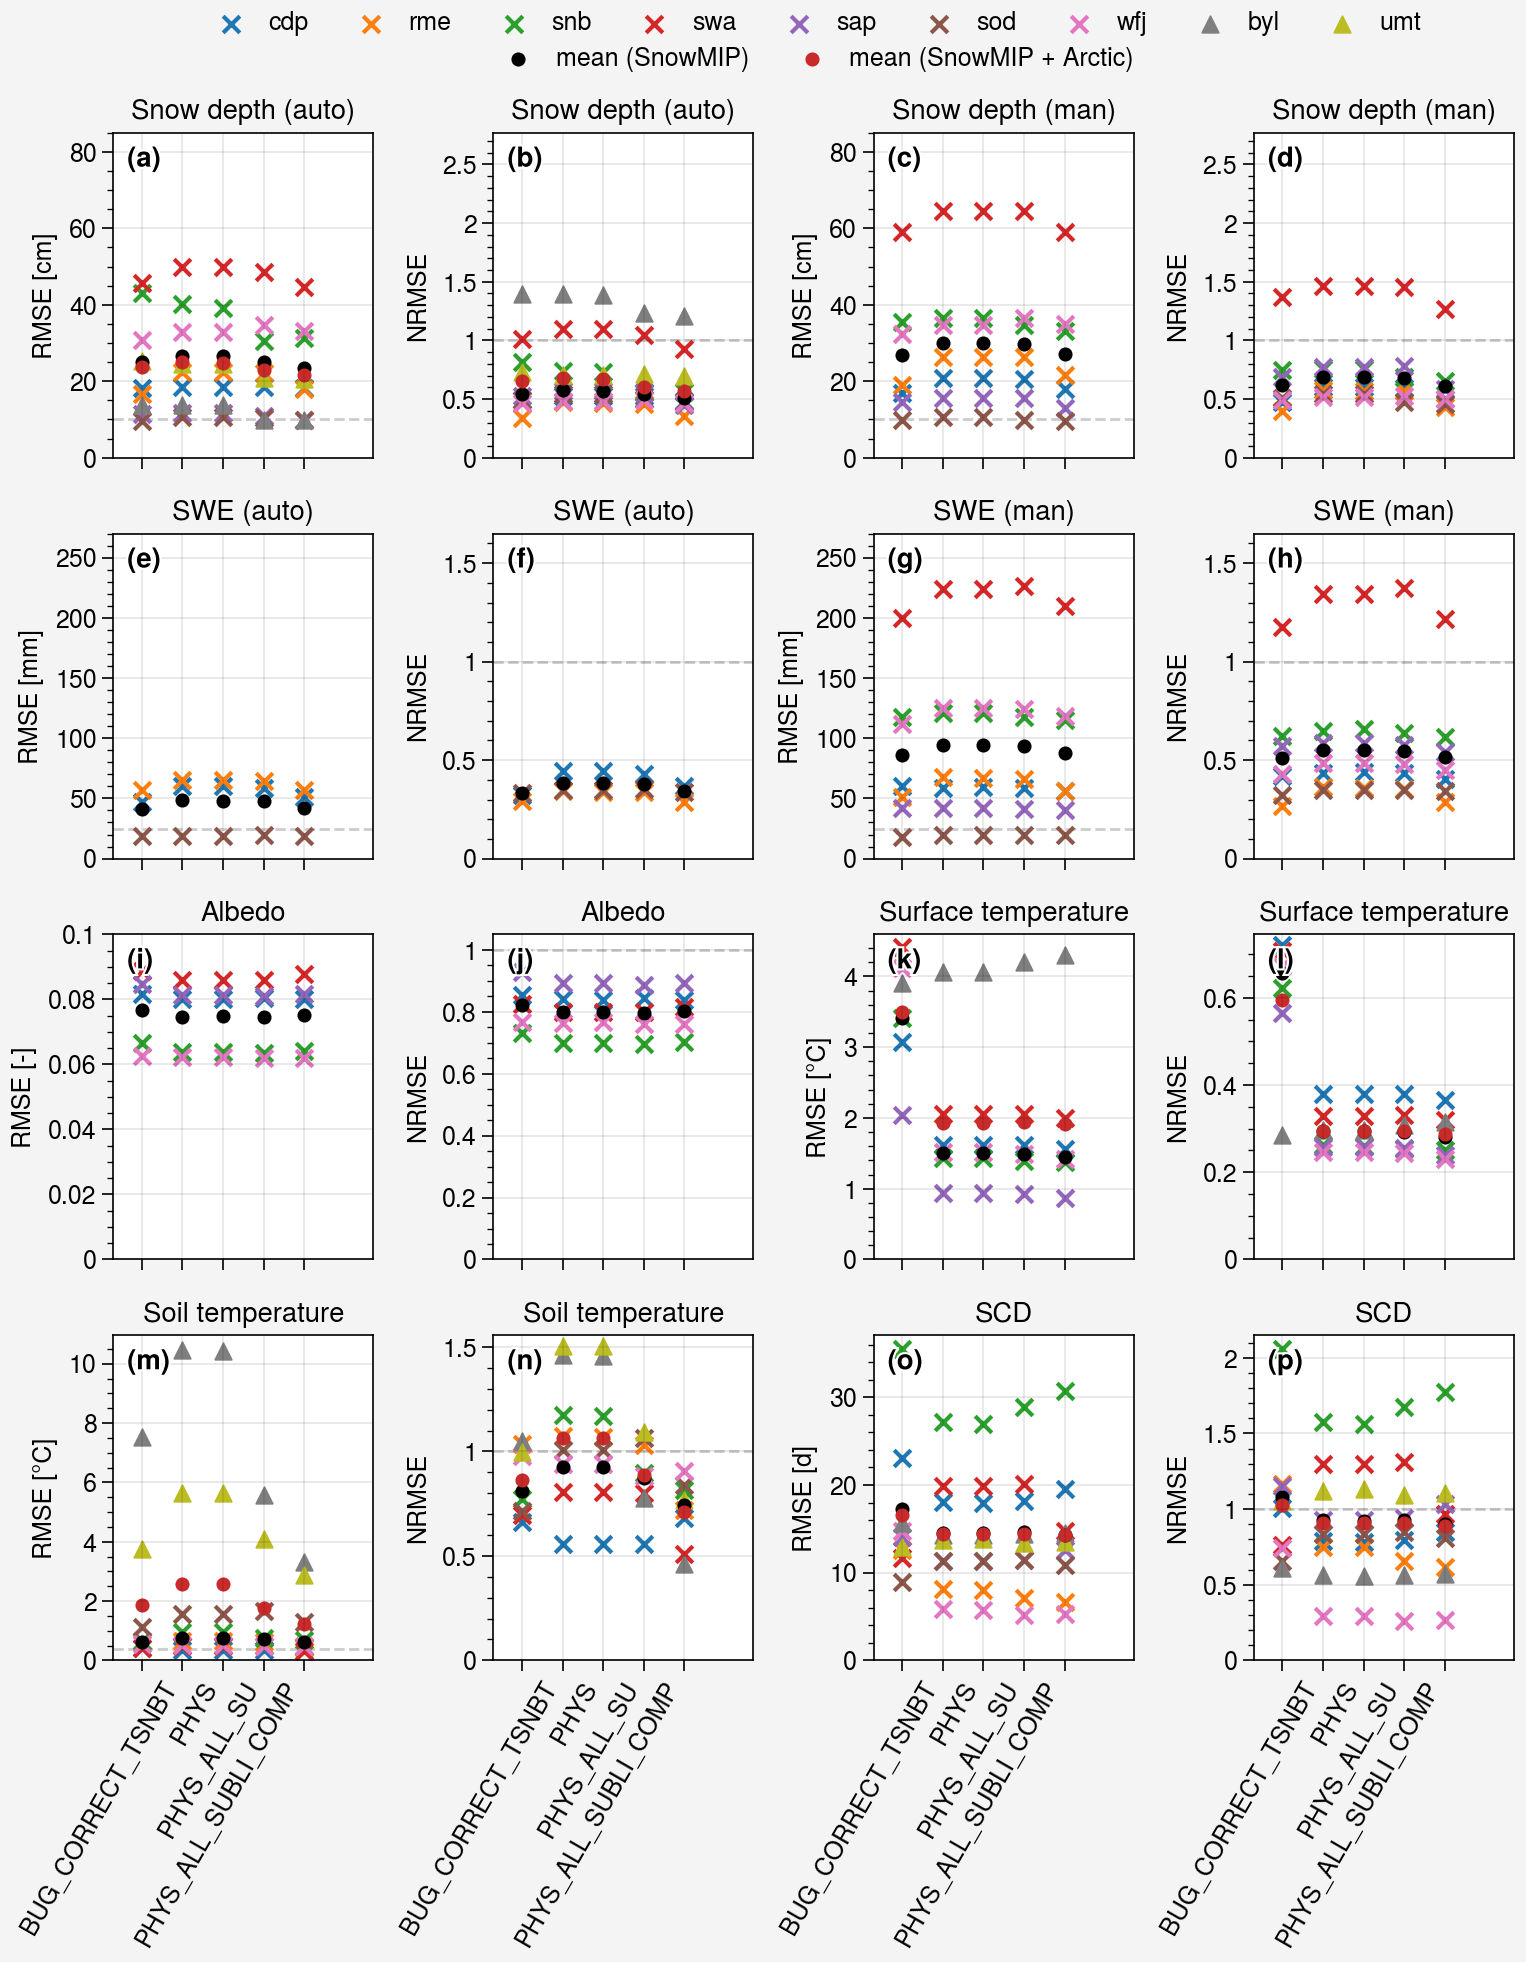

In [29]:
fig, axs = pplt.subplots(ncols=4, nrows=4, sharey=0, refaspect=0.8, refwidth=1.3)

colors = pplt.constructor.Cycle('default').by_key()['color']+pplt.constructor.Cycle('Accent').by_key()['color']
xrotation = 60
markers = ['x']*len(SnowMIP_sites) + ['^']*len(SnowArctic_sites)
marker_mean='.'; label_mean='mean (SnowMIP)'; color_mean='k'; marker_mean_size=80
marker_mean_arc='.'; label_mean_arc='mean (SnowMIP + Arctic)'; color_mean_arc='red9'; marker_mean_arc_size=80

# Snow depth
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[0].scatter(df_metrics_list[i].loc[('snd_auto')].rmse[1:]*100, marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[0].scatter(df_gather.loc[('snd_auto')].rmse[1:].apply(np.mean)*100, 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
h_mean_arc = axs[0].scatter(df_gather_Arctic.loc[('snd_auto')].rmse[1:].apply(np.mean)*100, 
                        marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[0].format(title='Snow depth (auto)', ylabel='RMSE [cm]', xrotation=xrotation, ylim=(0, 85))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[2].scatter(df_metrics_list[i].loc[('snd_man')].rmse[1:]*100, marker=markers[i], label=site.name, color=colors[i])
axs[2].scatter(df_gather.loc[('snd_man')].rmse[1:].apply(np.mean)*100, 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[2].scatter(df_gather_Arctic.loc[('snd_man')].rmse[1:].apply(np.nanmean)*100, 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[2].format(title='Snow depth (man)', ylabel='RMSE [cm]', xrotation=xrotation, ylim=(0, 85))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[1].scatter(df_metrics_list[i].loc[('snd_auto')].rmse[1:]/df_metrics_list[i].loc[('snd_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[1].scatter(df_gather.loc[('snd_auto')].nrmse[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[1].scatter(df_gather_Arctic.loc[('snd_auto')].nrmse[1:].apply(np.mean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
# axs[1].format(title='Snow depth (auto)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.58))
axs[1].format(title='Snow depth (auto)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 2.77))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[3].scatter(df_metrics_list[i].loc[('snd_man')].rmse[1:]/df_metrics_list[i].loc[('snd_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[3].scatter(df_gather.loc[('snd_man')].nrmse[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[3].scatter(df_gather_Arctic.loc[('snd_man')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[3].format(title='Snow depth (man)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 2.77))


# Snow Water Equivalent
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[4].scatter(df_metrics_list[i].loc[('snw_auto')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[4].scatter(df_gather.loc[('snw_auto')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[4].scatter(df_gather_Arctic.loc[('snw_auto')].rmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[4].format(title='SWE (auto)', ylabel='RMSE [mm]', xrotation=xrotation, ylim=(0, 270))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[6].scatter(df_metrics_list[i].loc[('snw_man')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
axs[6].scatter(df_gather.loc[('snw_man')].rmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[6].scatter(df_gather_Arctic.loc[('snw_man')].rmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[6].format(title='SWE (man)', ylabel='RMSE [mm]', xrotation=xrotation, ylim=(0, 270))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[5].scatter(df_metrics_list[i].loc[('snw_auto')].rmse[1:]/df_metrics_list[i].loc[('snw_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[5].scatter(df_gather.loc[('snw_auto')].nrmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[5].scatter(df_gather_Arctic.loc[('snw_auto')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[5].format(title='SWE (auto)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.65))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[7].scatter(df_metrics_list[i].loc[('snw_man')].rmse[1:]/df_metrics_list[i].loc[('snw_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[7].scatter(df_gather.loc[('snw_man')].nrmse[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[7].scatter(df_gather_Arctic.loc[('snw_man')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[7].format(title='SWE (man)', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.65))


# Albedo
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[8].scatter(df_metrics_list[i].loc[('albs')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[8].scatter(df_gather.loc[('albs')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[8].scatter(df_gather_Arctic.loc[('albs')].rmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[8].format(title='Albedo', ylabel='RMSE [-]', xrotation=xrotation, ylim=(0, 0.1))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[9].scatter(df_metrics_list[i].loc[('albs')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[9].scatter(df_gather.loc[('albs')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[9].scatter(df_gather_Arctic.loc[('albs')].nrmse[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[9].format(title='Albedo', ylabel='NRMSE', xrotation=xrotation, ylim=(0, 1.05))

# Surface temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[10].scatter(df_metrics_list[i].loc[('ts')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[10].scatter(df_gather.loc[('ts')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[10].scatter(df_gather_Arctic.loc[('ts')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[10].format(title='Surface temperature', ylabel='RMSE [°C]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[11].scatter(df_metrics_list[i].loc[('ts')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[11].scatter(df_gather.loc[('ts')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[11].scatter(df_gather_Arctic.loc[('ts')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[11].format(title='Surface temperature', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

# Soil temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[12].scatter(df_metrics_list[i].loc[('tsl')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[12].scatter(df_gather.loc[('tsl')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[12].scatter(df_gather_Arctic.loc[('tsl')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[12].format(title='Soil temperature', ylabel='RMSE [°C]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[13].scatter(df_metrics_list[i].loc[('tsl')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[13].scatter(df_gather.loc[('tsl')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[13].scatter(df_gather_Arctic.loc[('tsl')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[13].format(title='Soil temperature', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

# SCD
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[14].scatter(df_metrics_list[i].loc[('SCD')].rmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[14].scatter(df_gather.loc[('SCD')].rmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[14].scatter(df_gather_Arctic.loc[('SCD')].rmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[14].format(title='SCD', ylabel='RMSE [d]', xrotation=xrotation, ylim=(0, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[15].scatter(df_metrics_list[i].loc[('SCD')].nrmse[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[15].scatter(df_gather.loc[('SCD')].nrmse[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[15].scatter(df_gather_Arctic.loc[('SCD')].nrmse[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[15].format(title='SCD', ylabel='NRMSE', xrotation=xrotation, ylim=(0, None))

x_min = -0.7
# x_max = 2.7
x_max = 5.7
for i, ax in enumerate(axs):
    # ax.format(xticklabels=['CLASS']+[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    ax.format(xticklabels=[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    if (i % 2) != 0:
        ax.hlines(1, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# Snow Depth uncertainty
axs[0].hlines(10, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[2].hlines(10, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# SWE uncertainty
axs[4].hlines(25, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[6].hlines(25, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

# Soil temp uncertainty
axs[12].hlines(0.4, x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

    
fig.legend(h_list+[h_mean, h_mean_arc], loc='t', ncols=len(SnowMIP_sites)+len(SnowArctic_sites), center=True, frame=False)
fig.format(abc='(a)', abcloc='ul')
# fig.save('img/tn1_rmse.jpg')

### Scores

#### NRMSE

In [30]:
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].nrmse[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([0.67110762, 0.6426937 , 0.64170251, 0.62911976, 0.58906726])

In [31]:
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].nrmse[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([0.67743062, 0.67067736, 0.66989162, 0.63596107, 0.59179144])

#### Score (no weights)

In [32]:
# No weight (I guess not good because raising the score because of lesser stations for SWE_auto
# -> raising artificially the score
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([0.32889238, 0.3573063 , 0.35829749, 0.37088024, 0.41093274])

In [33]:
# No weight (I guess not good because raising the score because of lesser stations for SWE_auto
# -> raising artificially the score
score_array = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
score_array = np.array(score_array).mean(axis=0)
score_array

array([0.32256938, 0.32932264, 0.33010838, 0.36403893, 0.40820856])

#### Score (weights)

In [34]:
# Best score?
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites (give twice more weight to sn from auto/man)
    # Make sense because other variable have smaller std and so higher NRMSE
    # (which might give them too much importance)
    # weight = np.nansum(df_gather.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    weight = np.nansum(df_gather.loc[(var)].score[1:]['DEF']*0+1)
    # if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
    #     weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([0.30877283, 0.33310719, 0.33420658, 0.34751834, 0.38926546])

In [35]:
# Best score?
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites (give twice more weight to sn from auto/man)
    # Make sense because other variable have smaller std and so higher NRMSE
    # (which might give them too much importance)
    # weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
    weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['DEF']*0+1)
    # if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
    #     weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([0.28531418, 0.28951234, 0.29046577, 0.33132975, 0.37947458])

In [36]:
# # Best score?
# score_array = []
# weights = []
# for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
#     score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
#     # Weight per obs sites (give twice more weight to sn from auto/man)
#     # Make sense because other variable have smaller std and so higher NRMSE
#     # (which might give them too much importance)
#     weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['Ref_30min_ext']*0+1)
#     # if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
#     #     weight = weight*0.5
#     weights.append(weight)
# score_array = np.average(np.array(score_array), axis=0, weights=weights)
# score_array

In [37]:
# Alternative score
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites and 0.5 for sn auto/man
    weight = np.nansum(df_gather.loc[(var)].score[1:]['DEF']*0+1)
    if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
        weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([0.2528867 , 0.30211939, 0.30329217, 0.31665236, 0.35837992])

In [38]:
# Alternative score
score_array = []
weights = []
for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
    score_array.append(df_gather_Arctic.loc[(var)].score[1:].apply(np.nanmean).values)
    # Weight per obs sites and 0.5 for sn auto/man
    weight = np.nansum(df_gather_Arctic.loc[(var)].score[1:]['DEF']*0+1)
    if var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man']:
        weight = weight*0.5
    weights.append(weight)
score_array = np.average(np.array(score_array), axis=0, weights=weights)
score_array

array([0.23894457, 0.25834988, 0.25922889, 0.30349677, 0.35441207])

### Mean bias

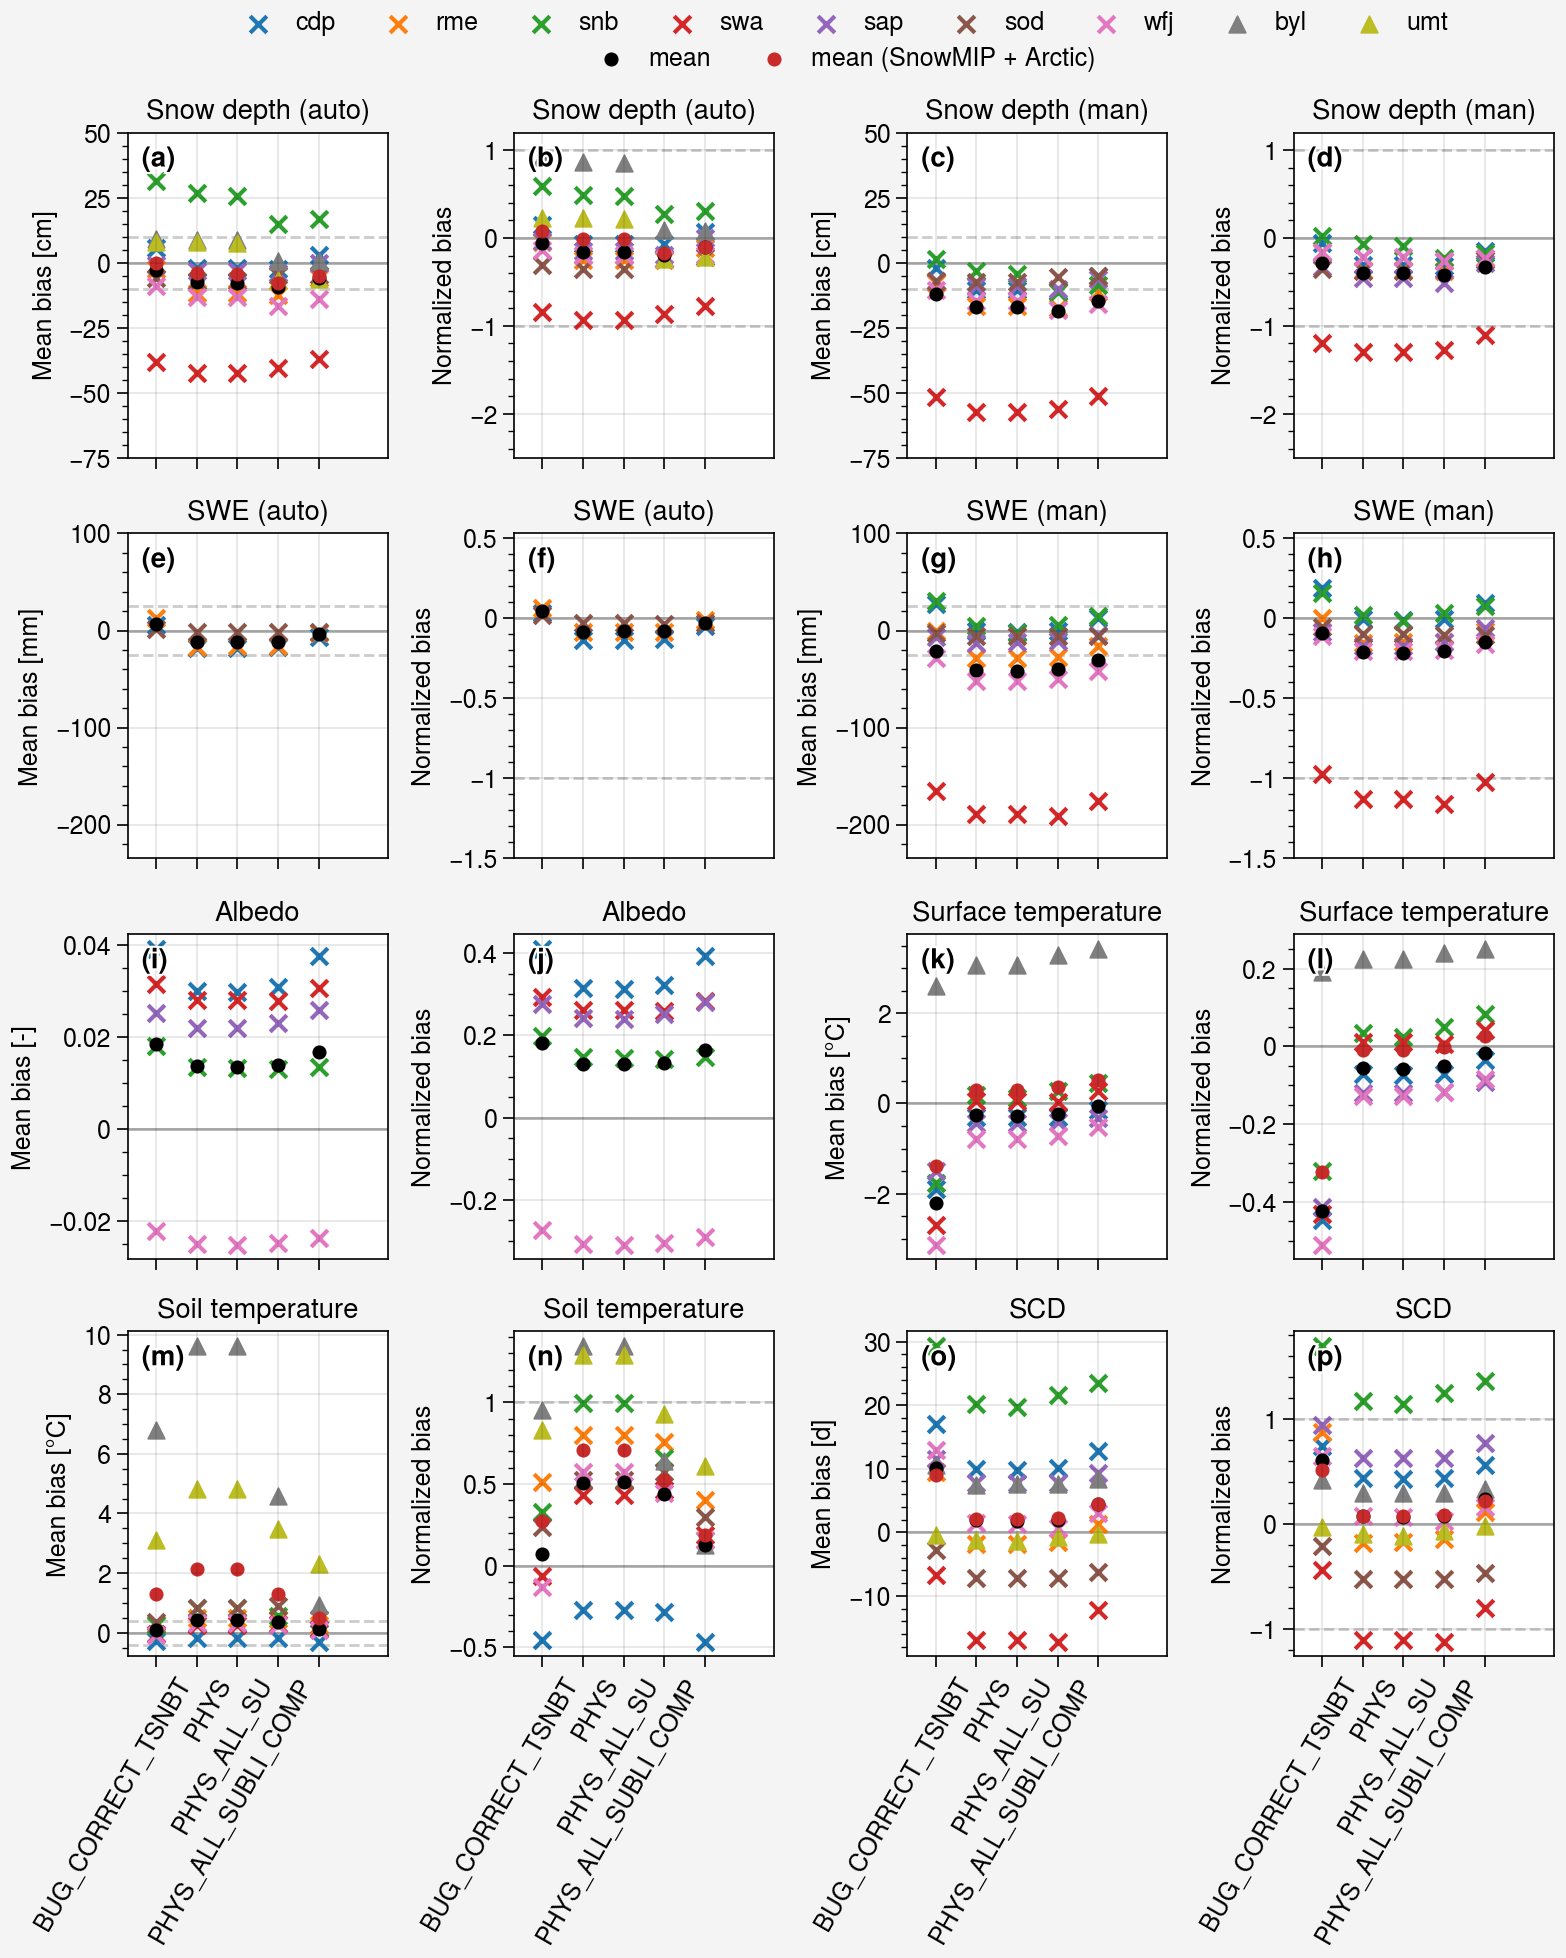

In [39]:
fig, axs = pplt.subplots(ncols=4, nrows=4, sharey=0, refaspect=0.8, refwidth=1.3)

colors = pplt.constructor.Cycle('default').by_key()['color']+pplt.constructor.Cycle('Accent').by_key()['color']
xrotation=60
markers = ['x']*len(SnowMIP_sites) + ['^']*len(SnowArctic_sites)
marker_mean='.'; label_mean='mean'; color_mean='k'; marker_mean_size=80
marker_mean_arc='.'; label_mean_arc='mean (SnowMIP + Arctic)'; color_mean_arc='red9'; marker_mean_arc_size=80

# Snow depth
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[0].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[0].scatter(df_gather.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
h_mean_arc = axs[0].scatter(df_gather_Arctic.loc[('snd_auto')].mb[1:].apply(np.mean)*100, 
                        marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[0].format(title='Snow depth (auto)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-75, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[2].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]*100, marker=markers[i], label=site.name, color=colors[i])
axs[2].scatter(df_gather.loc[('snd_man')].mb[1:].apply(np.mean)*100, 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[2].scatter(df_gather_Arctic.loc[('snd_man')].mb[1:].apply(np.nanmean)*100, 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[2].format(title='Snow depth (man)', ylabel='Mean bias [cm]', xrotation=xrotation, ylim=(-75, 50))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[1].scatter(df_metrics_list[i].loc[('snd_auto')].mb[1:]/df_metrics_list[i].loc[('snd_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[1].scatter(df_gather.loc[('snd_auto')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[1].scatter(df_gather_Arctic.loc[('snd_auto')].nmb[1:].apply(np.mean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[1].format(title='Snow depth (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-2.5, 1.2))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[3].scatter(df_metrics_list[i].loc[('snd_man')].mb[1:]/df_metrics_list[i].loc[('snd_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[3].scatter(df_gather.loc[('snd_man')].nmb[1:].apply(np.mean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[3].scatter(df_gather_Arctic.loc[('snd_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[3].format(title='Snow depth (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-2.5, 1.2))


# Snow Water Equivalent
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[4].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[4].scatter(df_gather.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[4].scatter(df_gather_Arctic.loc[('snw_auto')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[4].format(title='SWE (auto)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[6].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
axs[6].scatter(df_gather.loc[('snw_man')].mb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[6].scatter(df_gather_Arctic.loc[('snw_man')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[6].format(title='SWE (man)', ylabel='Mean bias [mm]', xrotation=xrotation, ylim=(-235, 100))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[5].scatter(df_metrics_list[i].loc[('snw_auto')].mb[1:]/df_metrics_list[i].loc[('snw_auto')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[5].scatter(df_gather.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[5].scatter(df_gather_Arctic.loc[('snw_auto')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[5].format(title='SWE (auto)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.5, 0.53))

for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    axs[7].scatter(df_metrics_list[i].loc[('snw_man')].mb[1:]/df_metrics_list[i].loc[('snw_man')].stdd[1:], 
                   marker=markers[i], label=site.name, color=colors[i])
axs[7].scatter(df_gather.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
               marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[7].scatter(df_gather_Arctic.loc[('snw_man')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[7].format(title='SWE (man)', ylabel='Normalized bias', xrotation=xrotation, ylim=(-1.5, 0.53))


# Albedo
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[8].scatter(df_metrics_list[i].loc[('albs')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[8].scatter(df_gather.loc[('albs')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[8].scatter(df_gather_Arctic.loc[('albs')].mb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[8].format(title='Albedo', ylabel='Mean bias [-]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[9].scatter(df_metrics_list[i].loc[('albs')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[9].scatter(df_gather.loc[('albs')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
# axs[9].scatter(df_gather_Arctic.loc[('albs')].nmb[1:].apply(np.nanmean), 
#                 marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[9].format(title='Albedo', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# Surface temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[10].scatter(df_metrics_list[i].loc[('ts')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[10].scatter(df_gather.loc[('ts')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[10].scatter(df_gather_Arctic.loc[('ts')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[10].format(title='Surface temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[11].scatter(df_metrics_list[i].loc[('ts')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[11].scatter(df_gather.loc[('ts')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[11].scatter(df_gather_Arctic.loc[('ts')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[11].format(title='Surface temperature', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# Soil temperature
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[12].scatter(df_metrics_list[i].loc[('tsl')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[12].scatter(df_gather.loc[('tsl')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[12].scatter(df_gather_Arctic.loc[('tsl')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[12].format(title='Soil temperature', ylabel='Mean bias [°C]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[13].scatter(df_metrics_list[i].loc[('tsl')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[13].scatter(df_gather.loc[('tsl')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[13].scatter(df_gather_Arctic.loc[('tsl')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[13].format(title='Soil temperature', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

# SCD
h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[14].scatter(df_metrics_list[i].loc[('SCD')].mb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[14].scatter(df_gather.loc[('SCD')].mb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[14].scatter(df_gather_Arctic.loc[('SCD')].mb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[14].format(title='SCD', ylabel='Mean bias [d]', xrotation=xrotation, ylim=(None, None))

h_list = []
for i, site in enumerate(SnowMIP_sites+SnowArctic_sites):
    h = axs[15].scatter(df_metrics_list[i].loc[('SCD')].nmb[1:], marker=markers[i], label=site.name, color=colors[i])
    h_list.append(h)
h_mean = axs[15].scatter(df_gather.loc[('SCD')].nmb[1:].apply(np.nanmean), 
                        marker=marker_mean, label=label_mean, color=color_mean, markersize=marker_mean_size)
axs[15].scatter(df_gather_Arctic.loc[('SCD')].nmb[1:].apply(np.nanmean), 
                marker=marker_mean_arc, label=label_mean_arc, color=color_mean_arc, markersize=marker_mean_arc_size)
axs[15].format(title='SCD', ylabel='Normalized bias', xrotation=xrotation, ylim=(None, None))

x_min = -0.7
x_max = 5.7
for ax in axs:
    # ax.format(xticklabels=['CLASS']+[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    ax.format(xticklabels=[exp[:-10] for exp in exps], xlim=(x_min, x_max))
    ax.hlines(0, x_min, x_max, color='k', lw=1, alpha=0.3, zorder=0, ls='-')

# Obs uncertainties (base on Lejeune et al. (2019) at cdp)
axs[0].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[2].hlines([-10, 10], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[4].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')
axs[6].hlines([-25, 25], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

axs[12].hlines([-0.4, 0.4], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

for i, ax in enumerate(axs):
    if (i % 2) != 0:
        ax.hlines([-1, 1], x_min, x_max, color='k', lw=1, alpha=0.2, zorder=0, ls='--')

    
fig.legend(h_list+[h_mean, h_mean_arc], loc='t', ncols=len(SnowMIP_sites)+len(SnowArctic_sites), center=True, frame=False)
fig.format(abc='(a)', abcloc='ul')
# fig.save('img/tn1_mb.jpg')

In [40]:
# for var in ['snd_auto', 'snd_man', 'snw_auto', 'snw_man', 'albs', 'ts', 'tsl', 'SCD']:
for var in ['SCD']:
    print('### SnowMIP ###')
    print('MB')
    print('df_gather.loc[('+var+')].mb[1:]')
    print(df_gather.loc[(var)].mb[1:].apply(np.nanmean))
    
    print('\ndf_gather.loc[('+var+')].nmb[1:]')
    print(df_gather.loc[(var)].nmb[1:].apply(np.nanmean))

    print('\nRMSE')
    print('df_gather.loc[('+var+')]rmse[1:]')
    print(df_gather.loc[(var)].rmse[1:].apply(np.nanmean))
    
    print('\ndf_gather.loc[('+var+')].nrmse[1:]')
    print(df_gather.loc[(var)].nrmse[1:].apply(np.nanmean))
    
    
    print('\n### SnowMIP + Arctic ###')
    print('MB')
    print('df_gather_Arctic.loc[('+var+')].mb[1:]')
    print(df_gather_Arctic.loc[(var)].mb[1:].apply(np.nanmean))
    
    print('\ndf_gather_Arctic.loc[('+var+')].nmb[1:]')
    print(df_gather_Arctic.loc[(var)].nmb[1:].apply(np.nanmean))

    print('\nRMSE')
    print('df_gather_Arctic.loc[('+var+')]rmse[1:]')
    print(df_gather_Arctic.loc[(var)].rmse[1:].apply(np.nanmean))
    
    print('\ndf_gather_Arctic.loc[('+var+')].nrmse[1:]')
    print(df_gather_Arctic.loc[(var)].nrmse[1:].apply(np.nanmean))



### SnowMIP ###
MB
df_gather.loc[(SCD)].mb[1:]
DEF                              10.092957
BUG_CORRECT_TSNBT_OP1_EZERO       1.907463
PHYS_ALL_SUBLI                    1.832393
PHYS_ALL_SUBLI_COMPAC             2.010124
PHYS_ALL_SUBLI_COMPAC_calonne     4.497419
Name: mb, dtype: float64

df_gather.loc[(SCD)].nmb[1:]
DEF                              0.608817
BUG_CORRECT_TSNBT_OP1_EZERO      0.071256
PHYS_ALL_SUBLI                   0.067695
PHYS_ALL_SUBLI_COMPAC            0.079278
PHYS_ALL_SUBLI_COMPAC_calonne    0.242199
Name: nmb, dtype: float64

RMSE
df_gather.loc[(SCD)]rmse[1:]
DEF                              17.242428
BUG_CORRECT_TSNBT_OP1_EZERO      14.549068
PHYS_ALL_SUBLI                   14.472975
PHYS_ALL_SUBLI_COMPAC            14.629568
PHYS_ALL_SUBLI_COMPAC_calonne    14.354576
Name: rmse, dtype: float64

df_gather.loc[(SCD)].nrmse[1:]
DEF                              1.079422
BUG_CORRECT_TSNBT_OP1_EZERO      0.925819
PHYS_ALL_SUBLI                   0.921674
PHYS_ALL_SUB